In [3]:
from fastai2.basics import *
from fastai2.vision.all import *

import kornia
from mish_cuda import MishCuda

from tqdm.notebook import tqdm

import astropy.io.ascii
from astropy.coordinates import SkyCoord, matching
import astropy.units as u

PATH = Path('../..').resolve()

%matplotlib inline

seed = 12345

In [4]:
torch.cuda.set_device('cuda:1')

# reproducability flags
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

item_tfms = []
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize.from_stats(*image_stats)]

def root_mean_squared_error(preds, targs):  return torch.sqrt(F.mse_loss(preds.reshape(-1, 1), targs.reshape(-1, 1)))
def slope(p, y): return ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

def summary_stats(preds, trues, mask):
    """Given preds, trues, and some PR conditional mask, 
    output the total number (N), RMSE, slope, std, and offset.
    """    
    return (
        sum(mask), 
        ((preds[mask] - trues[mask])**2).mean()**0.5, 
        slope(preds[mask], trues[mask]),
        (preds[mask] - trues[mask]).std(), 
        (preds[mask].mean() - trues[mask].mean()),
    )


# allow ColReader to look in different `pref` paths if needed
class ModifiedColReader():
    "Read `cols` in `row` with potential `pref` and `suff`"
    def __init__(self, cols, pref='', suff='', label_delim=None):
        store_attr(self, 'suff,label_delim')
        self.pref = str(pref) + os.path.sep if isinstance(pref, Path) else pref
        self.cols = L(cols)

    def _do_one(self, r, c):
        o = r[c] if isinstance(c, int) else r[c] if c=='name' else getattr(r, c)
        if len(self.pref)==0 and len(self.suff)==0 and self.label_delim is None: return o
        if self.label_delim is None and len(o) < 10: return f'{PATH}/images-OC/{o}{self.suff}'
        elif self.label_delim is None and len(o) >= 10: return f'{PATH}/images-nondetections/{o}{self.suff}' 
        else: return o.split(self.label_delim) if len(o)>0 else []

    def __call__(self, o, **kwargs):
        if len(self.cols) == 1: return self._do_one(o, self.cols[0])
        return L(self._do_one(o, c) for c in self.cols)


# Get data sources

## ALFALFA

- `a40A`: $\alpha.40$A sample, $N=7399$, Haynes et al. (2011)
- `a40B`: $\alpha.40$B sample, $N=4797$
  * = `a40A` crossmatched to SDSS galaxies
  * cuts for systems with valid SFR, M*, metallicity, and redshift measurements
- `a100`: $\alpha.100$ cleaned sample, $N=11432$, Haynes et al. (2018)
  * crossmatched to SDSS 
  * 55" cuts for SDSS fiber collisions
  * 1.9' cuts for ALFALFA beam overlap
  
## xGASS
- `xg`: extended GASS representative sample, $N=1179$, Catinella et al. (2018)

## NIBLES
- `nib`: NIBLES sample, $N=941$, van Driel et al. (2016)
  * crossmatched to SDSS galaxies (with $gri$ imaging)
  * removed crossmatches to ALFALFA and xGASS

In [54]:
a40A = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', index_col='AGCNr', usecols=(1,2)).join(
    pd.read_csv(f'{PATH}/data/a40.datafile1.csv', index_col='AGCNr'), rsuffix='_r',
)

a40A.shape

(7399, 18)

In [55]:
a40B = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv', index_col='AGCNr', usecols=(1,2)).join(
    pd.read_csv(f'{PATH}/data/a40.datafile1.csv', index_col='AGCNr'), rsuffix='_r',
).reindex()

a40B.shape

(4797, 18)

In [56]:
a100 = pd.read_csv(f'{PATH}/data/a100_cleaned_sdss.csv')
a100.shape

(11432, 62)

In [57]:
xg = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")
xg.shape

(1179, 42)

In [58]:
nibles = pd.read_csv(f'{PATH}/data/NIBLES_clean.csv')
nibles = nibles[(nibles.logMstar > 8) & np.isfinite(nibles.logfgas)]

nible_ids = np.array([p.stem for p in list(PATH.glob(pattern='images-nibles_cleaned/*.jpg'))], dtype=int)

nibles.set_index('nibles_id', inplace=True)
nibles.drop([obj for obj in nibles.index if obj not in nible_ids], inplace=True)
nibles.reset_index(inplace=True)
nibles.nibles_id = nibles.nibles_id.astype(str)

nibles.shape

(941, 10)

## Remove overlap with xGASS via crossmatch, and save to `{ROOT}/data/final/`

Use 55" cutoff

In [59]:
xg_coords = SkyCoord(xg.RA, xg.DEC, unit=u.deg)
a40A_coords = SkyCoord(a40A.RAdeg_OC, a40A.DECdeg_OC, unit=u.deg)
a40B_coords = SkyCoord(a40B.RAdeg_OC, a40B.DECdeg_OC, unit=u.deg)
a100_coords = SkyCoord(a100.RAdeg_OC, a100.DECdeg_OC, unit=u.deg)
nib_coords = SkyCoord(nibles.ra, nibles.dec, unit=u.deg)

In [60]:
_, a40A_sep, _ = matching.match_coordinates_sky(a40A_coords, xg_coords, nthneighbor=1)
_, a40B_sep, _ = matching.match_coordinates_sky(a40B_coords, xg_coords, nthneighbor=1)
_, a100_sep, _ = matching.match_coordinates_sky(a100_coords, xg_coords, nthneighbor=1)
_, nib_sep, _ = matching.match_coordinates_sky(nib_coords, xg_coords, nthneighbor=1)

In [61]:
cutoff = 1*u.arcsec
sum(a40A_sep < cutoff), sum(a40B_sep < cutoff), sum(a100_sep < cutoff), sum(nib_sep < cutoff)

(158, 81, 215, 41)

In [62]:
cutoff = 55*u.arcsec
sum(a40A_sep < cutoff), sum(a40B_sep < cutoff), sum(a100_sep < cutoff), sum(nib_sep < cutoff)

(271, 153, 216, 42)

In [63]:
cutoff = 55*u.arcsec

a40A[a40A_sep > cutoff].to_csv(f'{PATH}/data/final/a40A.csv')
a40B[a40B_sep > cutoff].to_csv(f'{PATH}/data/final/a40B.csv')

nibles[nib_sep > cutoff].to_csv(f'{PATH}/data/final/nibles.csv')
xg.to_csv(f'{PATH}/data/final/xGASS.csv')

## Specify which members of $\alpha$.100 are not in $\alpha.40$A catalog (`not_in_a40A`)

In [64]:
cutoff = 1*u.arcsec

a40A_coords = SkyCoord(a40A.RAdeg_OC, a40A.DECdeg_OC, unit=u.deg)
a100_coords = SkyCoord(a100.RAdeg_OC, a100.DECdeg_OC, unit=u.deg)

_, a100_x_a40_sep, _ = matching.match_coordinates_sky(a100_coords, a40A_coords, nthneighbor=1)

a100['not_in_a40A'] = a100_x_a40_sep > cutoff

a100.to_csv(f'{PATH}/data/final/a100.csv')

## Get non-overlapping catalogs/show sizes

In [69]:
a40A = pd.read_csv(f'{PATH}/data/final/a40A.csv')
a40B = pd.read_csv(f'{PATH}/data/final/a40B.csv')
a100 = pd.read_csv(f'{PATH}/data/final/a100.csv')
nib = pd.read_csv(f'{PATH}/data/final/nibles.csv', dtype={'nibles_id': str})
xg = pd.read_csv(f'{PATH}/data/final/xGASS.csv')

In [5]:
len(a40A), len(a40B), len(a100[a100.not_in_a40A]), len(a100), len(nib), len(xg)

(7128, 4644, 6087, 11432, 899, 1179)

# Get predictions for xresnet34 trained on $\alpha$.40A

## Retrieve trained CNN from nb `90.`

In [68]:
a40A_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=FuncSplitter(lambda x: False),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

a40A_dls = ImageDataLoaders.from_dblock(a40A_dblock, a40A, path=PATH, bs=64)

In [69]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(a40A_dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn = learn.load('fastai2-xresnet34-a40A-1');

## Get predictions on $\alpha$.40A

In [115]:
a40A_dl = ImageDataLoaders.from_dblock(a40A_dblock, a40A, path=PATH, bs=128, shuffle_train=False, drop_last=False).train

a40A_idx = a40A_dl.items.AGCNr
a40A_preds, a40A_trues = learn.get_preds(dl=a40A_dl, reorder=False)

a40A_results = pd.DataFrame(
    {
        'fgas_pred': to_np(a40A_preds.view(-1)),
        'fgas_true': to_np(a40A_trues.view(-1)),
    }, index=a40A_idx.astype(int)
)

list(map(
    partial(np.round, decimals=4), 
    summary_stats(a40A_results.fgas_pred, a40A_results.fgas_true, np.ones_like(a40A_results.fgas_true, dtype=bool))
))    

[7128, 0.2335, 0.8427, 0.2318, 0.0285]

In [116]:
a40A_results.to_csv(f'{PATH}/results/final/a40A_predictions.csv')

## Get predictions for $\alpha$.100 (not in $\alpha.40$)

In [70]:
a100_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=ColSplitter(col='not_in_a40A'),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)


In [71]:
a100_dl = ImageDataLoaders.from_dblock(a100_dblock, a100, path=PATH, bs=128, drop_last=False).valid

a100_idx = a100_dl.items.AGCNr
a100_preds, a100_trues = learn.get_preds(dl=a100_dl, reorder=False)

a100_results = pd.DataFrame(
    {
        'fgas_pred': to_np(a100_preds.view(-1)),
        'fgas_true': to_np(a100_trues.view(-1)),
    }, index=a100_idx.astype(int)
)

list(map(
    partial(np.round, decimals=4), 
    summary_stats(a100_results.fgas_pred, a100_results.fgas_true, np.ones_like(a100_results.fgas_true, dtype=bool))
))

[6087, 0.2975, 0.7325, 0.2974, -0.0076]

In [72]:
a100_results.to_csv(f'{PATH}/results/final/a100_predictions.csv')

## Get predictions for xGASS

In [99]:
xg_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['GASS'], pref=f'{PATH}/images-xGASS/', suff='.jpg'),
    get_y=Pipeline([ColReader(['lgGF'], label_delim=None)]),
    splitter=FuncSplitter(lambda x: False),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [124]:
xg_dl = ImageDataLoaders.from_dblock(xg_dblock, xg, path=PATH, bs=128, shuffle_train=False, drop_last=False).train

xg_idx = xg_dl.items.GASS
xg_preds, xg_trues = learn.get_preds(dl=xg_dl, reorder=False)

xg_results = pd.DataFrame(
    {
        'fgas_pred': to_np(xg_preds.view(-1)),
        'fgas_true': to_np(xg_trues.view(-1))
    }, index=xg_idx.astype(int)
)

list(map(
    partial(np.round, decimals=4), 
    summary_stats(xg_results.fgas_pred, xg_results.fgas_true, np.ones_like(xg_results.fgas_true, dtype=bool))
))

[1179, 0.6254, 0.4724, 0.4284, 0.4558]

In [125]:
xg_results.to_csv(f'{PATH}/results/final/xgass_predictions.csv')

## Get predictions for NIBLES

In [126]:
nib_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['nibles_id'], pref=f'{PATH}/images-nibles_cleaned/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=FuncSplitter(lambda x: False),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [127]:
nib_dl = ImageDataLoaders.from_dblock(nib_dblock, nib, path=PATH, bs=128, shuffle_train=False, drop_last=False).train

nib_idx = nib_dl.items.nibles_id
nib_preds, nib_trues = learn.get_preds(dl=nib_dl, reorder=False)

nib_results = pd.DataFrame(
    {
        'fgas_pred': to_np(nib_preds.view(-1)),
        'fgas_true': to_np(nib_trues.view(-1)),
    }, index=nib_idx.astype(int)
)

list(map(
    partial(np.round, decimals=4), 
    summary_stats(nib_results.fgas_pred, nib_results.fgas_true, np.ones_like(nib_results.fgas_true, dtype=bool))
))

[899, 0.374, 0.8427, 0.348, 0.1375]

In [128]:
nib_results.to_csv(f'{PATH}/results/final/nibles_predictions.csv')

## Aside: training on $\alpha$.40B

In [61]:
a40B = pd.read_csv(f'{PATH}/data/final/a40B.csv').join(
    pd.read_csv('../../data/a40-SDSS_galaxy-properties.csv', index_col='AGCNr'), 
    on='AGCNr', rsuffix='_x', how='inner'
)

In [62]:
a40B_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

a40B_dls = ImageDataLoaders.from_dblock(a40B_dblock, a40B, path=PATH, bs=64)

In [25]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(a40B_dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn.fit_one_cycle(40, 1e-2)

In [26]:
learn.save('fastai2-xresnet34-a40B-1');

In [30]:
a40B_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=FuncSplitter(lambda x: None),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

a40B_dl = ImageDataLoaders.from_dblock(a40B_dblock, a40B, path=PATH, bs=128, shuffle_train=False, drop_last=False).train

a40B_idx = a40B_dl.items.AGCNr
a40B_preds, a40B_trues = learn.get_preds(dl=a40B_dl, reorder=False)

a40B_results = pd.DataFrame(
    {
        'fgas_pred': to_np(a40B_preds.view(-1)),
        'fgas_true': to_np(a40B_trues.view(-1)),
    }, index=a40B_idx.astype(int)
)

list(map(
    partial(np.round, decimals=4), 
    summary_stats(a40B_results.fgas_pred, a40B_results.fgas_true, np.ones_like(a40B_results.fgas_true, dtype=bool))
))    

[4644, 0.2349, 0.7797, 0.234, 0.0211]

In [31]:
# a40B_results.to_csv(f'{PATH}/results/final/a40B_predictions.csv')
a40B_results = pd.read_csv(f'{PATH}/results/final/a40B_predictions.csv')

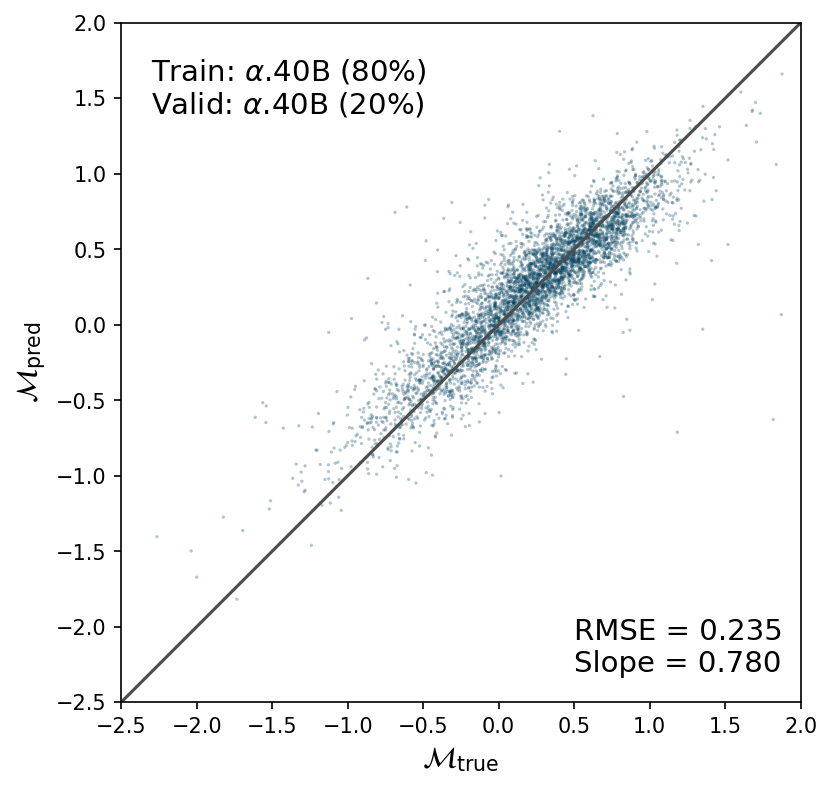

In [111]:
label = r'$\alpha$.40B'

plt.figure(figsize=(6, 6), dpi=150)

PR_accept = np.ones_like(a40B_results.fgas_true, dtype=bool)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(a40B_results.fgas_pred, a40B_results.fgas_true, PR_accept)


plt.scatter(
    a40B_results.fgas_true, 
    a40B_results.fgas_pred, 
    edgecolors='none', alpha=0.3,
    c='#003f5c', s=10, marker='.',
)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, f'Train: {label} (80%)' + '\n' + f'Valid: {label} (20%)', fontsize=14)
plt.text(0.5, -2.3, f'RMSE = {rmse_CNN:.3f}' + f'\nSlope = {slope_CNN:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.savefig(f'{PATH}/results/final/a40B-self_validation.pdf')

## Scatter plots for $\alpha$.40A self-validation -- retrain from scratch *just to be sure*

In [65]:
a40A = pd.read_csv(f'{PATH}/results/final/a40A_all.csv', dtype={'AGCNr': str})

a40A_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

a40A_dls = ImageDataLoaders.from_dblock(a40A_dblock, a40A, path=PATH, bs=64)

In [66]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(a40A_dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn.fit_one_cycle(40, 1e-2)

In [67]:
fgas_pred, fgas_true = learn.tta()

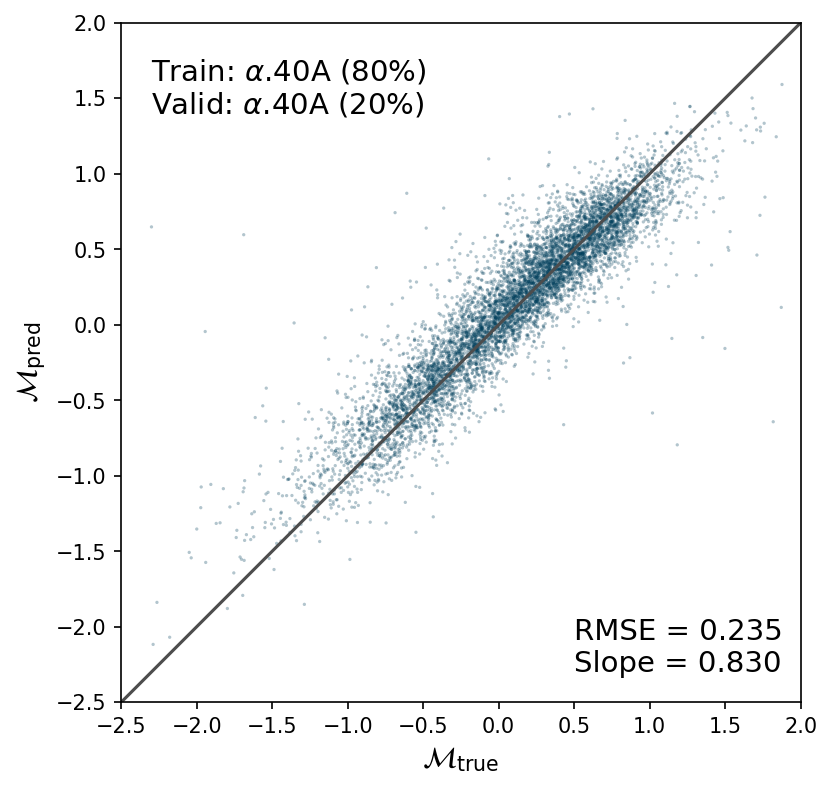

In [68]:
res = a40A
label = r'$\alpha$.40A'

plt.figure(figsize=(6, 6), dpi=150)

PR_accept = np.ones_like(fgas_true, dtype=bool)
# _, rmse_CNN, slope_CNN, _, _ = summary_stats(fgas_pred.view(-1), fgas_true.view(-1), PR_accept)

# for consistency, use CNN RMSE + slope in Table 2. 
# results here are generally consistent, e.g., 
#     RMSE = 0.219, 0.235, ... 
#    slope = 0.853, 0.830, ...


plt.scatter(
    a40A.fgas_true, 
    a40A.fgas_pred, 
    edgecolors='none', alpha=0.3,
    c='#003f5c', s=10, marker='.',
)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, f'Train: {label} (80%)' + '\n' + f'Valid: {label} (20%)', fontsize=14)
plt.text(0.5, -2.3, f'RMSE = {rmse_CNN:.3f}' + f'\nSlope = {slope_CNN:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.savefig(f'{PATH}/results/final/a40A-self_validation.pdf')

## Plot $\mathcal{M}$ residuals vs galaxy properties for $\alpha$.40B

In [63]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(a40B_dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn = learn.load('fastai2-xresnet34-a40A-1');

In [73]:
a40B_valid = learn.dls.valid_ds.items.copy()

In [80]:
a40B_valid.columns

Index(['AGCNr', 'DR7ObjID', 'Name', 'RAdeg_HI', 'Decdeg_HI', 'RAdeg_OC',
       'DECdeg_OC', 'Vhelio', 'W50', 'errW50', 'HIflux', 'errflux', 'SNR',
       'RMS', 'Dist', 'logMsun', 'HIcode', 'OCcode', 'NoteFlag', 'Unnamed: 0',
       'DR7ObjID_x', 'logMHI', 'logMstar', 'logSFR', 'Zgas', 'logfgas',
       'logsSFR', 'delta_M', 'z'],
      dtype='object')

In [74]:
preds, trues = learn.get_preds()
a40B_valid['delta_M'] = to_np(preds.view(-1) - trues.view(-1))
a40B_valid['z'] = a40B_valid.Dist * 70 / 3e5

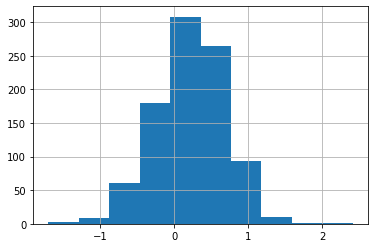

In [93]:
a40B_valid['logfgas'].hist()

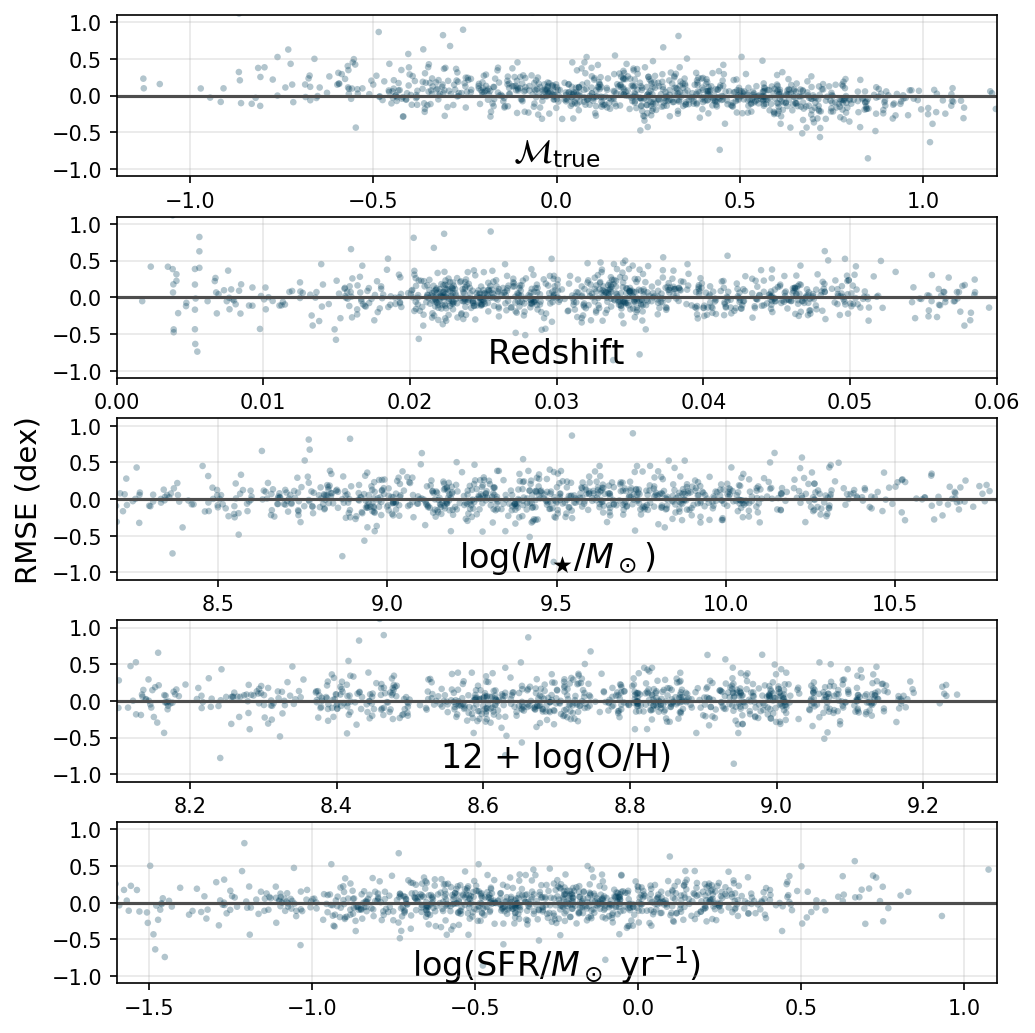

In [132]:
# plotting key
xs = ['logfgas', 'z', 'logMstar', 'Zgas', 'logSFR']
xlims = [(-1.2, 1.2), (0, 0.06), (8.2, 10.8), (8.1, 9.3), (-1.6, 1.1)]
xlabels = [r'$\mathcal{M}_{\rm true}$', 'Redshift', r'$\log(M_★/M_\odot)$', r'12 + log(O/H)', r'log(SFR/$M_\odot~{\rm yr}^{-1})$']
ls = ['HI mass fraction', r'Redshift', 'Stellar mass', 'Gas metallicity', 'Star formation rate']

# actual plot
fig, axes = plt.subplots(5, 1, figsize=(7, 7), dpi=150)
for [ax, x, xlim, xlabel, l] in zip(axes.flat, xs, xlims, xlabels, ls):
    
    ax.scatter(a40B_valid[x], a40B_valid.delta_M, edgecolors='none', alpha=0.3, c='#003f5c', s=40, marker='.')
#     ax.text(0.075, 0.075, l, transform=ax.transAxes, ha='center', fontsize=12)
    
    ax.axhline(0, c='0.3')
    
    ax.set_xlim(*xlim)
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel(xlabel, labelpad=-36, fontsize=16)
    ax.grid(alpha=0.3)

axes[2].set_ylabel('RMSE (dex)', fontsize=14)

fig.tight_layout()
plt.subplots_adjust(hspace=0.25)

plt.savefig(f'{PATH}/results/final/residual-trends_combined.pdf')

# Get CNN PR results

## Get model trained on $\alpha$.40A detections vs. $\alpha.100$ non-detections
- Balanced classes (7399 detections and 7399 non-detections)
- Trained using same architecture as before (xresnet34 with SA+Mish) and same number of epochs (40)
- Used label smoothing (eps=0.05) cross entropy

In [5]:
det = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})
nd = pd.read_csv(f'{PATH}/results/nondetections/a100-nd_himass_lowz.csv', dtype={'objID': str})

nd['detected'] = False
det['detected'] = True

det['objID'] = det.AGCNr.astype(str)
nd.objID = nd.objID.astype(str)

combined = pd.concat([
    det[['objID', 'detected']],
    nd[['objID', 'detected']].sample(7399, random_state=seed)
])

In [6]:
nd_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ModifiedColReader(['objID'], pref=(f'{PATH}/images-OC/'), suff='.jpg'),
    get_y=Pipeline([ColReader(['detected'])]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

nd_dls = ImageDataLoaders.from_dblock(nd_dblock, combined, path=PATH, bs=64)

In [7]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=2)

learn = Learner(
    nd_dls, 
    model, 
    opt_func=ranger, 
    loss_func=LabelSmoothingCrossEntropy(eps=0.05), 
    metrics=[accuracy, RocAuc()]
)

learn = learn.load('fastai2-xresnet34-non_detections_smoothed');

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


## Show results for 20% validation set

In [343]:
preds, trues = learn.get_preds()

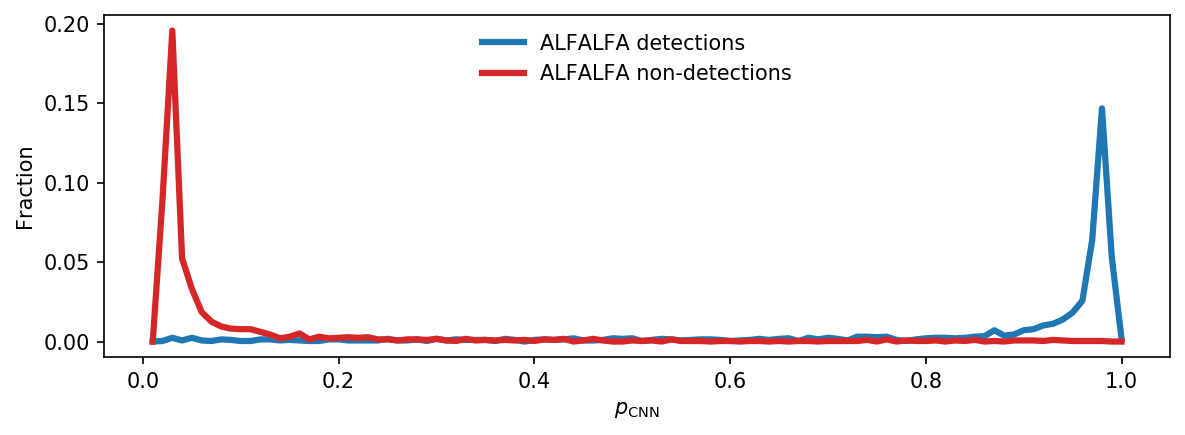

In [350]:
plt.figure(figsize=(8, 3), dpi=150)

y_det, x_det = np.histogram(preds[trues == 1][:,1], bins=100, range=(0,1))
y_non, x_non = np.histogram(preds[trues == 0][:,1], bins=100, range=(0,1))

plt.plot((x_det[:-1]+0.01), y_det / len(preds), lw=3, color='C0', label=r'ALFALFA detections')
plt.plot((x_non[:-1]+0.01), y_non / len(preds), lw=3, color='C3', label=r'ALFALFA non-detections')

plt.legend(loc='upper center', framealpha=0)

plt.ylabel('Fraction')
plt.xlabel(r'$p_{\rm CNN}$')
plt.tight_layout()

plt.savefig(f'{PATH}/results/final/CNN_PR_results.pdf');

## Get $p_{\rm CNN}$ for $\alpha$.40A

In [ ]:
%%capture

a40A_p_CNN = np.array([to_np(learn.predict(f'{PATH}/images-OC/{fn}.jpg')[2][1]) for fn in a40A.AGCNr])

In [ ]:
a40A_results = pd.read_csv(f'{PATH}/results/final/a40A_predictions.csv', index_col='AGCNr')
a40A_results['p_CNN'] = a40A_p_CNN

In [ ]:
plt.figure(figsize=(8, 3), dpi=150)

y_hist, x_hist = np.histogram(a40A_results.p_CNN, bins=100, range=(0,1))
plt.plot((x_hist[:-1]+0.01), y_hist / len(a40A_results), lw=3, color='C0', label=r'$\alpha$.40')

plt.legend(loc='upper center', framealpha=0)


plt.ylabel('Fraction')
plt.xlabel(r'$p_{\rm CNN}$');

In [ ]:
a40A = a40A.join(a40A_results, on='AGCNr', how='inner').set_index('AGCNr')
a40A.to_csv(f'{PATH}/results/final/a40A_all.csv')

## Get $p_{\rm CNN}$ for $\alpha$.100

In [ ]:
%%capture

a100_p_CNN = np.array([to_np(learn.predict(f'{PATH}/images-OC/{fn}.jpg')[2][1]) for fn in a100[a100.not_in_a40A].AGCNr])

In [ ]:
a100_results = pd.read_csv(f'{PATH}/results/final/a100_predictions.csv', index_col='AGCNr')
a100_results['p_CNN'] = a100_p_CNN

In [ ]:
plt.figure(figsize=(8, 3), dpi=150)

y_hist, x_hist = np.histogram(a100_results.p_CNN, bins=100, range=(0,1))
plt.plot((x_hist[:-1]+0.01), y_hist / len(a100_results), lw=3, color='C0', label=r'$\alpha$.100')

plt.legend(loc='upper center', framealpha=0)

plt.ylabel('Fraction')
plt.xlabel(r'$p_{\rm CNN}$');

In [ ]:
a100 = a100.drop([col for col in a100.columns if col.startswith('Unnamed:') or col.startswith('fgas_')], 1) 
a100 = a100.join(a100_results, on='AGCNr', how='inner').set_index('AGCNr')
a100.to_csv(f'{PATH}/results/final/a100_all.csv')

## Get $p_{\rm CNN}$ for xGASS

In [ ]:
%%capture

xg_p_CNN = np.array([to_np(learn.predict(f'{PATH}/images-xGASS/{fn}.jpg')[2][1]) for fn in xg.GASS])

In [ ]:
xg_results = pd.read_csv(f'{PATH}/results/final/xgass_predictions.csv', index_col='GASS')
xg_results['p_CNN'] = xg_p_CNN

In [ ]:
plt.figure(figsize=(8, 3), dpi=150)

y_hist, x_hist = np.histogram(xg_results.p_CNN, bins=100, range=(0,1))
plt.plot((x_hist[:-1]+0.01), y_hist / len(xg_results), lw=3, color='C0', label=r'xGASS')

plt.legend(loc='upper center', framealpha=0)

plt.ylabel('Fraction')
plt.xlabel(r'$p_{\rm CNN}$');

In [ ]:
xg = xg.drop([col for col in xg.columns if col.startswith('Unnamed:')], 1) 
xg = xg.join(xg_results, on='GASS', how='inner').set_index('GASS')
xg.to_csv(f'{PATH}/results/final/xgass_all.csv')

## Get $p_{\rm CNN}$ for NIBLES

In [ ]:
# from notebook 94.
nib = (
    pd.read_csv(
        f'{PATH}/results/predictions/nibles-v2_trained-on-a40.csv', index_col='nibles_id'
    ).loc[pd.read_csv(f'{PATH}/data/final/nibles.csv').nibles_id]
).drop('Unnamed: 0', 1)

nib.to_csv(f'{PATH}/results/final/nibles_all.csv')

In [ ]:
plt.figure(figsize=(8, 3), dpi=150)

y_hist, x_hist = np.histogram(nib.p_CNN, bins=100, range=(0,1))
plt.plot((x_hist[:-1]+0.01), y_hist / len(xg_results), lw=3, color='C0', label=r'NIBLES')

plt.legend(loc='upper center', framealpha=0)

plt.ylabel('Fraction')
plt.xlabel(r'$p_{\rm CNN}$');

## PR for all samples

In [8]:
a40A = pd.read_csv(f'{PATH}/results/final/a40A_all.csv')
a100 = pd.read_csv(f'{PATH}/results/final/a100_all.csv')
nib = pd.read_csv(f'{PATH}/results/final/nibles_all.csv')
xg = pd.read_csv(f'{PATH}/results/final/xgass_all.csv')

In [9]:
nd_preds, nd_trues = learn.get_preds()

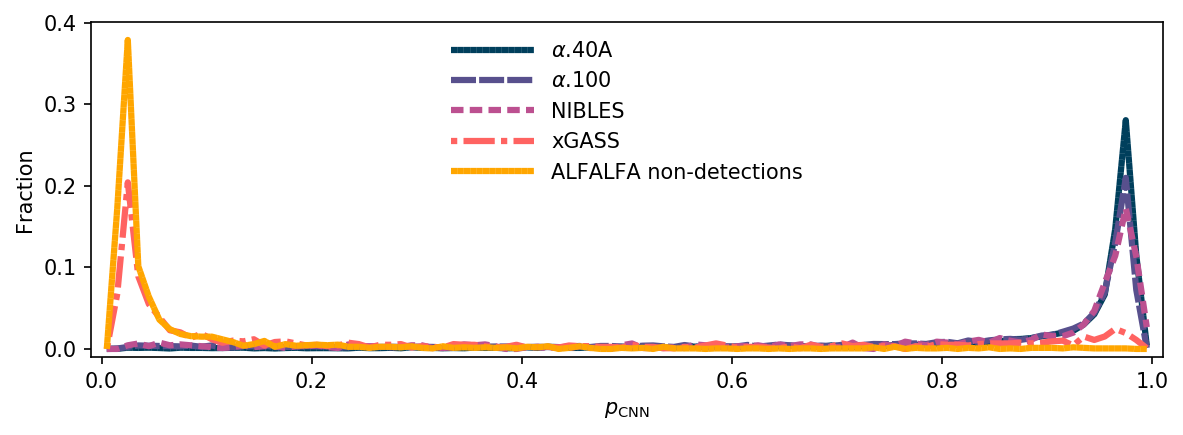

In [25]:
# plotting key
ps = [a40A.p_CNN, a100.p_CNN, nib.p_CNN, xg.p_CNN, nd_preds[nd_trues == 0][:,1]]
cs = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']
ls = [r'$\alpha$.40A', r'$\alpha$.100', 'NIBLES', 'xGASS', 'ALFALFA non-detections']
ds = [(1, 0.02), (4, 0.5), (2, 1), (1, 1, 5, 1), (1, 0.02)]

# actual plot
plt.figure(figsize=(8, 3), dpi=150)
for i, [p, c, l, d] in enumerate(zip(ps, cs, ls, ds)):
    y, x = np.histogram(p, bins=100, range=(0,1))
    plt.plot((x[:-1]+0.005), y/len(p), lw=3, color=c, dashes=d, label=l)

plt.legend(loc='upper center', framealpha=0, handlelength=4)

plt.ylabel('Fraction')
plt.xlabel(r'$p_{\rm CNN}$');

plt.ylim(-0.01, 0.401)
plt.xlim(-0.01, 1.01)
plt.tight_layout()

# plt.savefig(f'{PATH}/results/final/CNN_PR_results_all.pdf')

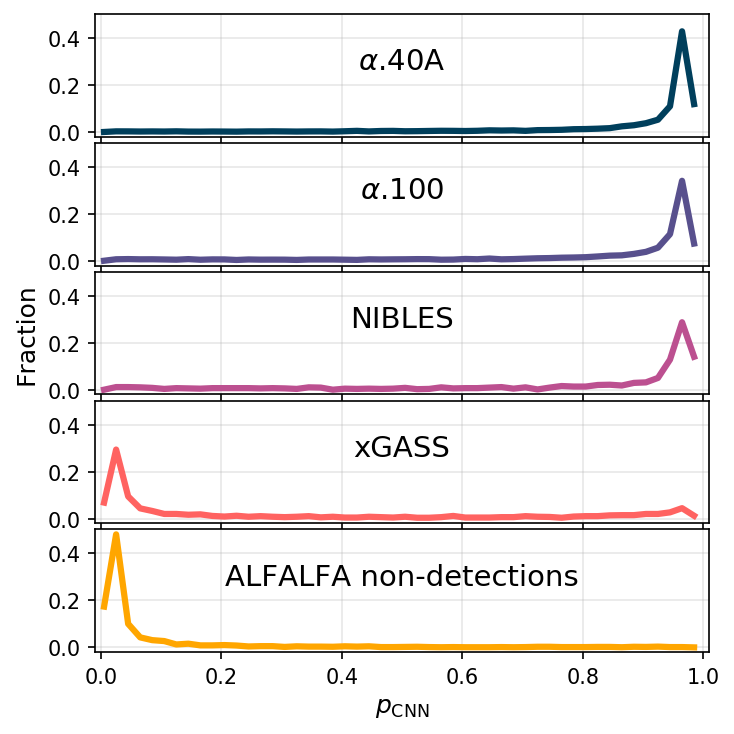

In [60]:
# plotting key
ps = [a40A.p_CNN, a100.p_CNN, nib.p_CNN, xg.p_CNN, nd_preds[nd_trues == 0][:,1]]
cs = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']
ls = [r'$\alpha$.40A', r'$\alpha$.100', 'NIBLES', 'xGASS', 'ALFALFA non-detections']

# actual plot
fig, axes = plt.subplots(5, 1, figsize=(5, 5), dpi=150, sharex=True)
for i, [ax, p, c, l] in enumerate(zip(axes.flat, ps, cs, ls)):
    y, x = np.histogram(p, bins=50, range=(0,1))
    ax.plot((x[:-1]+0.005), y/len(p), lw=3, color=c, label=l)

    ax.text(0.5, 0.55, l, transform=ax.transAxes, ha='center', fontsize=14)
    
    ax.set_yticks([0, 0.2, 0.4])
    ax.set_ylim(-0.02, 0.502)
    ax.grid(alpha=0.3)

axes[2].set_ylabel('Fraction', fontsize=12)
axes[-1].set_xlabel(r'$p_{\rm CNN}$', fontsize=12);

# plt.ylim(-0.01, 0.401)
plt.xlim(-0.01, 1.01)
plt.tight_layout()

plt.subplots_adjust(hspace=0.05)

plt.savefig(f'{PATH}/results/final/CNN_PR_results_all.pdf')

# Results using CNN PR

## $p_{\rm CNN} > 0.5$ | RMSE + slope

In [ ]:
p = 0.5

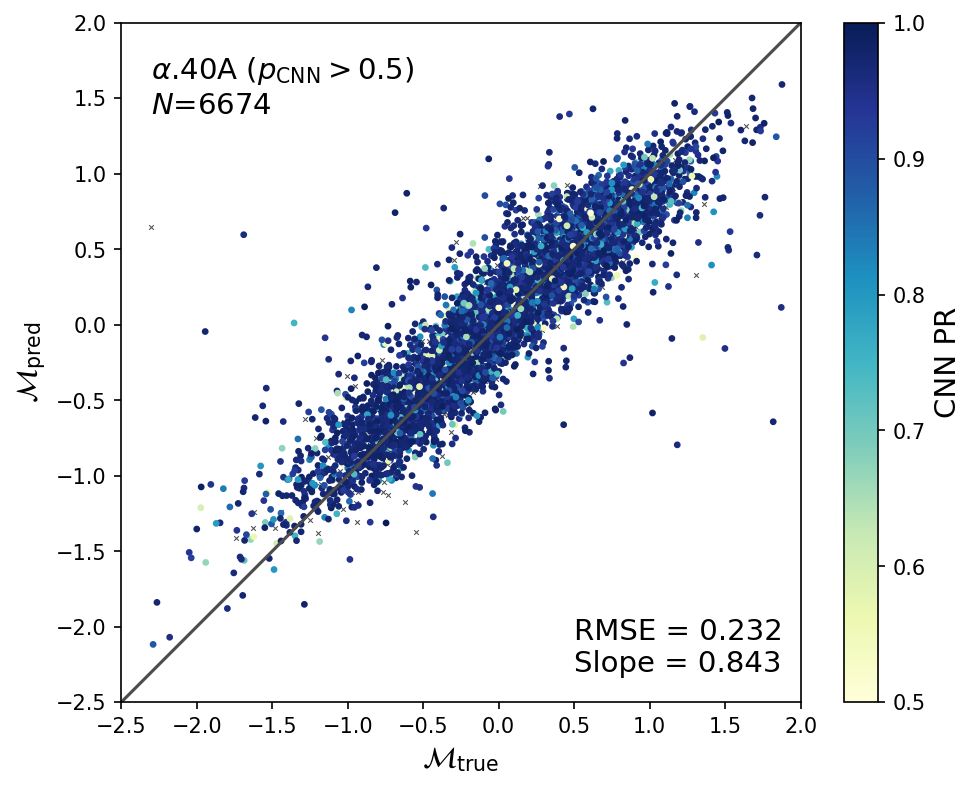

In [189]:
res = a40A
label = r'$\alpha$.40A'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(0.5, -2.3, f'RMSE = {stats[1]:.3f}' + f'\nSlope = {stats[2]:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


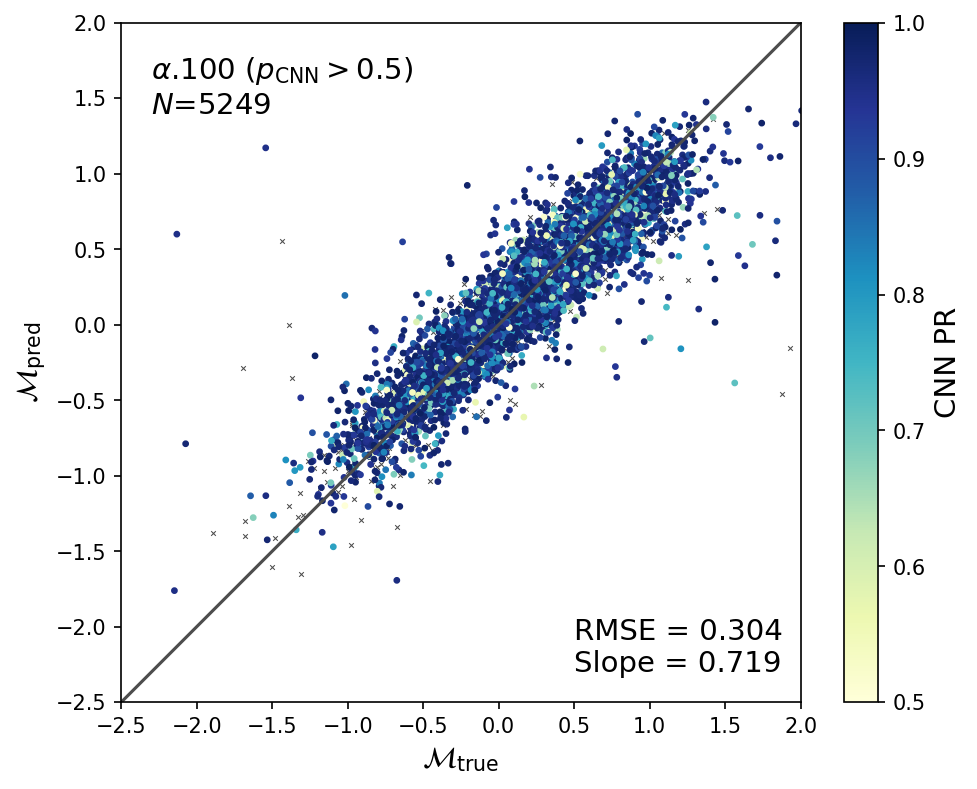

In [190]:
res = a100
label = r'$\alpha$.100'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(0.5, -2.3, f'RMSE = {stats[1]:.3f}' + f'\nSlope = {stats[2]:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


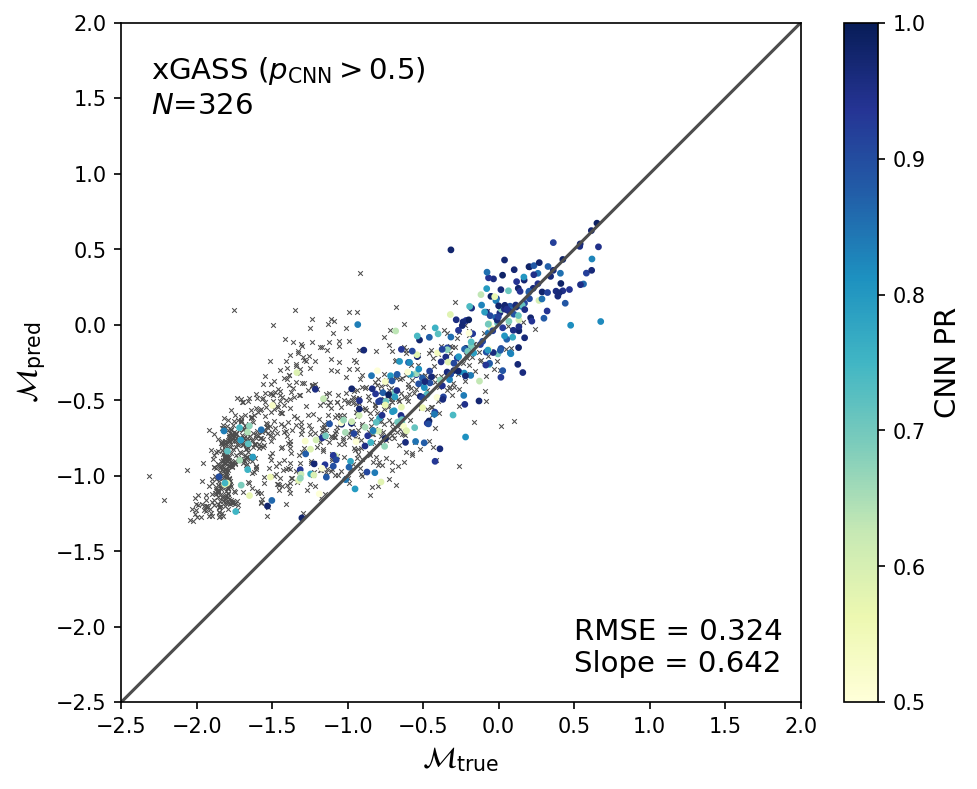

In [191]:
res = xg
label = r'xGASS'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(0.5, -2.3, f'RMSE = {stats[1]:.3f}' + f'\nSlope = {stats[2]:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


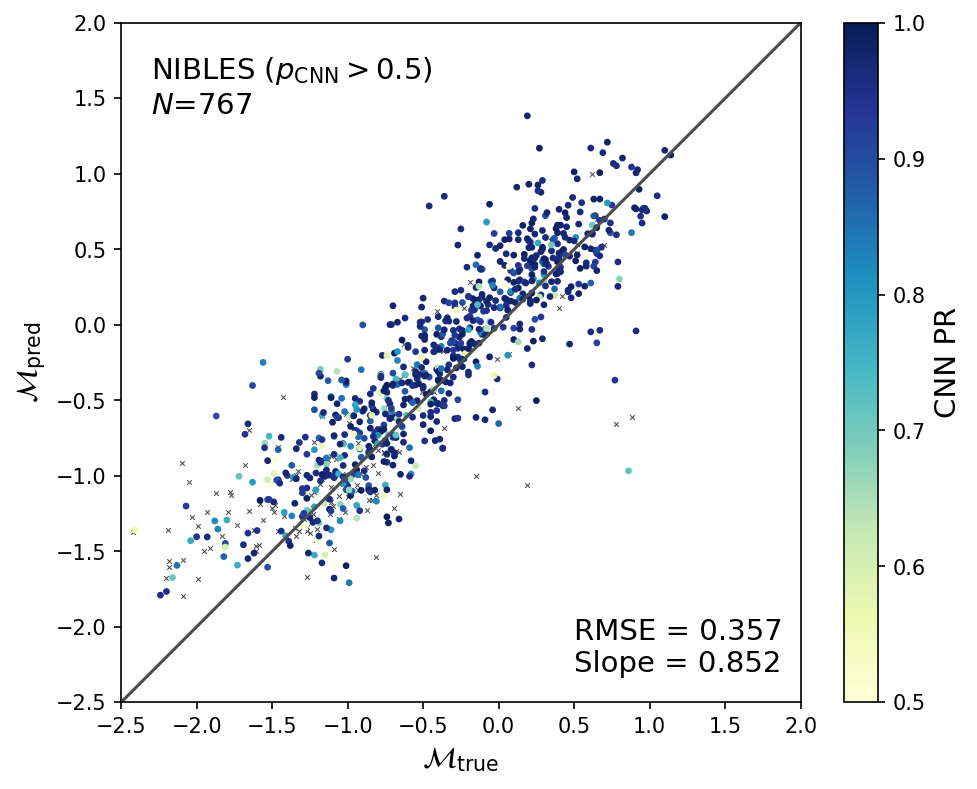

In [193]:
res = nib
label = r'NIBLES'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(0.5, -2.3, f'RMSE = {stats[1]:.3f}' + f'\nSlope = {stats[2]:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


## $p_{\rm CNN} > 0.5$ | $\sigma$ + offset

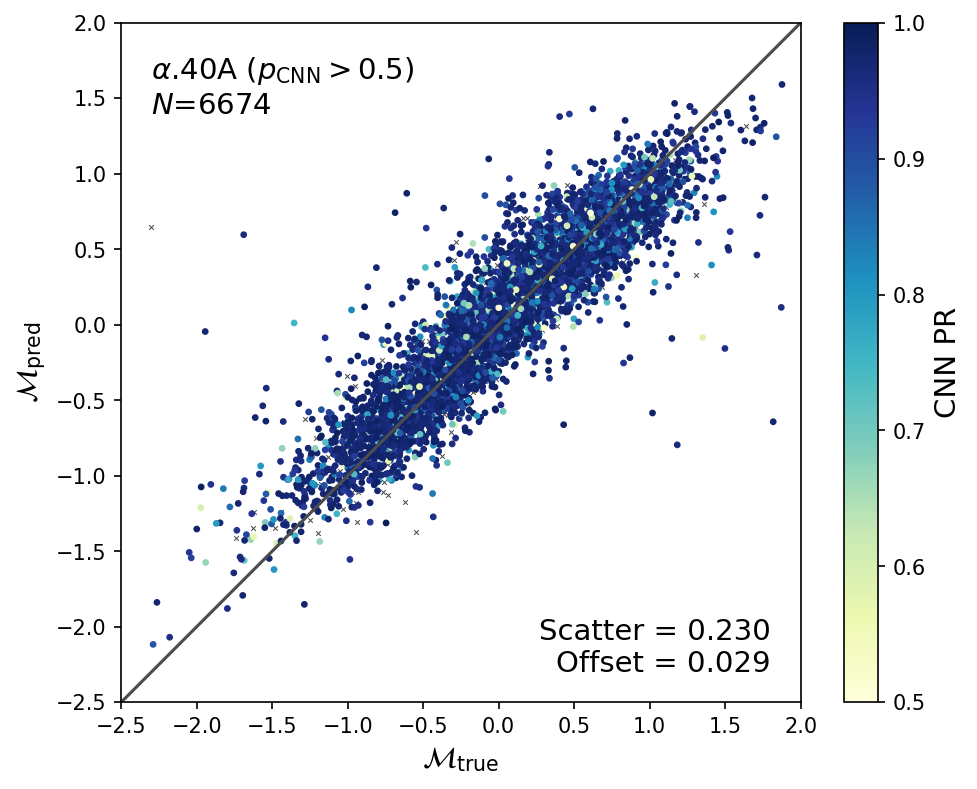

In [195]:
res = a40A
label = r'$\alpha$.40A'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(1.8, -2.3, f'Scatter = {stats[3]:.3f}' + f'\nOffset = {stats[4]:.3f}', fontsize=14, ha='right')

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


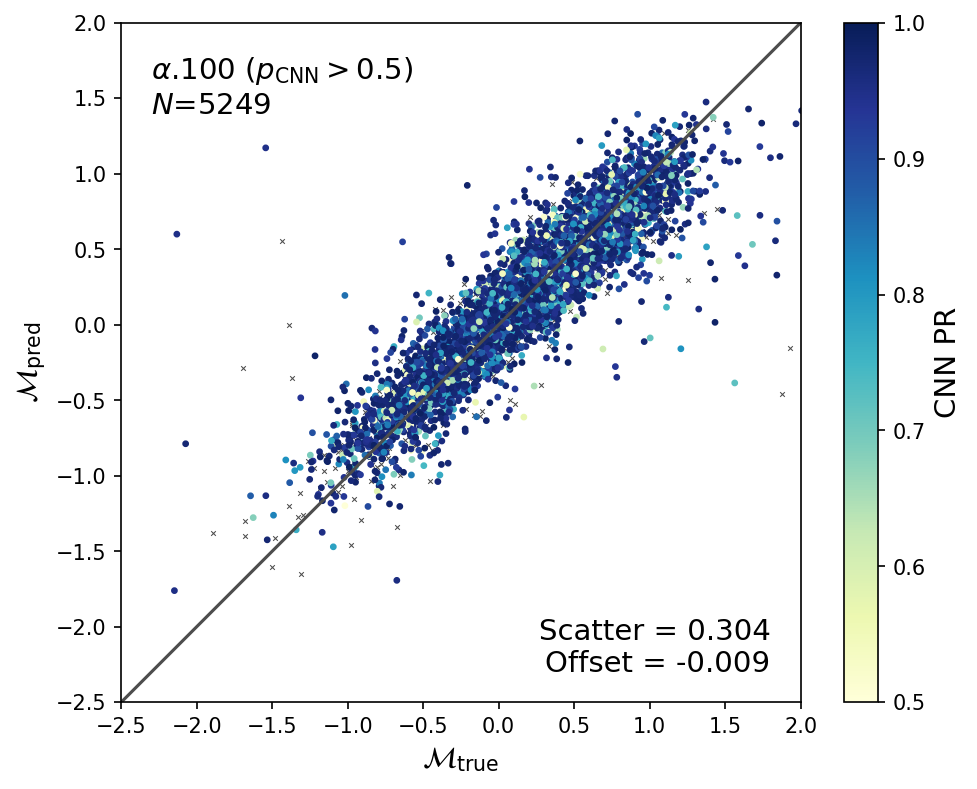

In [196]:
res = a100
label = r'$\alpha$.100'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(1.8, -2.3, f'Scatter = {stats[3]:.3f}' + f'\nOffset = {stats[4]:.3f}', fontsize=14, ha='right')

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


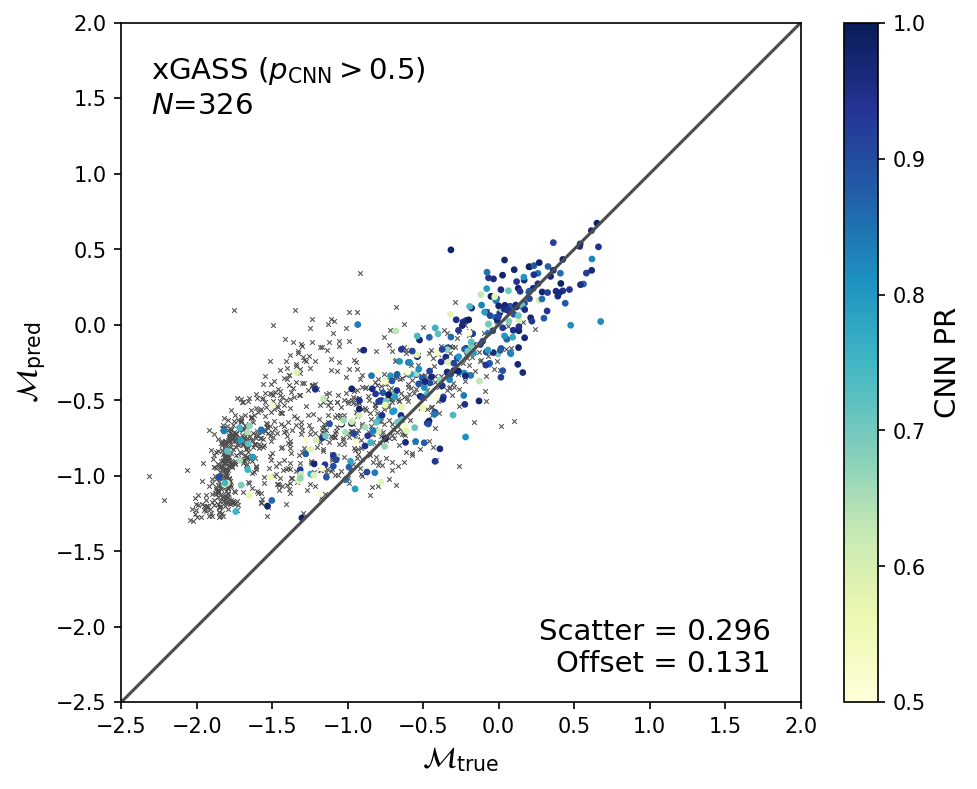

In [197]:
res = xg
label = r'xGASS'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(1.8, -2.3, f'Scatter = {stats[3]:.3f}' + f'\nOffset = {stats[4]:.3f}', fontsize=14, ha='right')

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


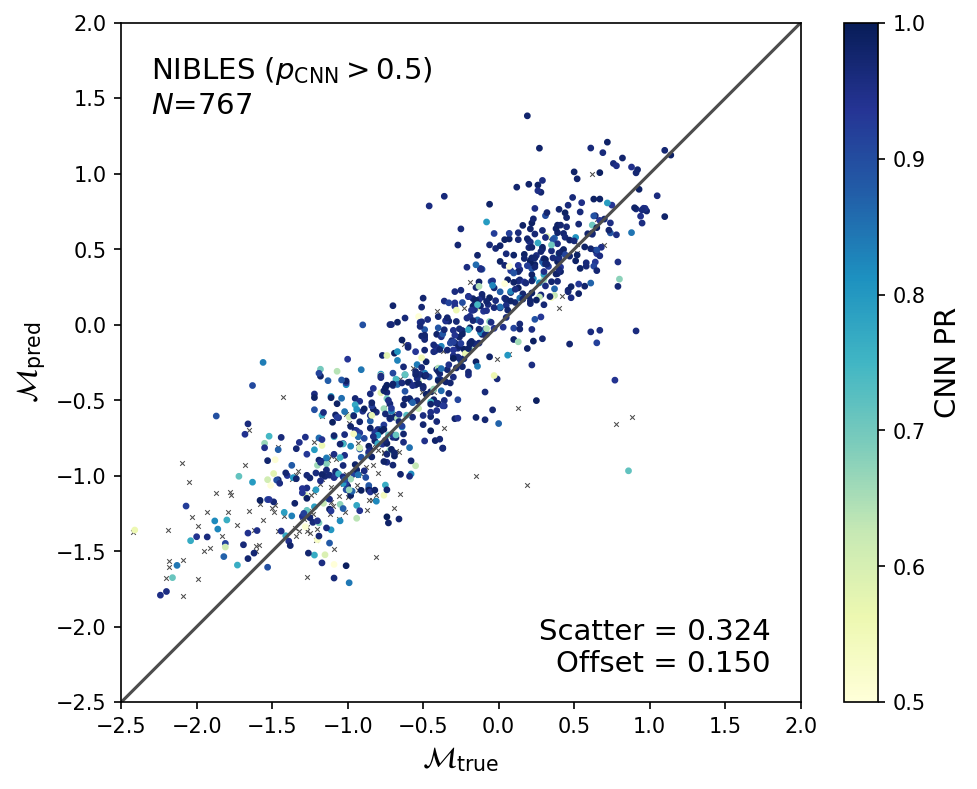

In [198]:
res = nib
label = r'NIBLES'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(1.8, -2.3, f'Scatter = {stats[3]:.3f}' + f'\nOffset = {stats[4]:.3f}', fontsize=14, ha='right')

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


## $p_{\rm CNN} > 0.9$ | RMSE + slope

In [199]:
p = 0.9

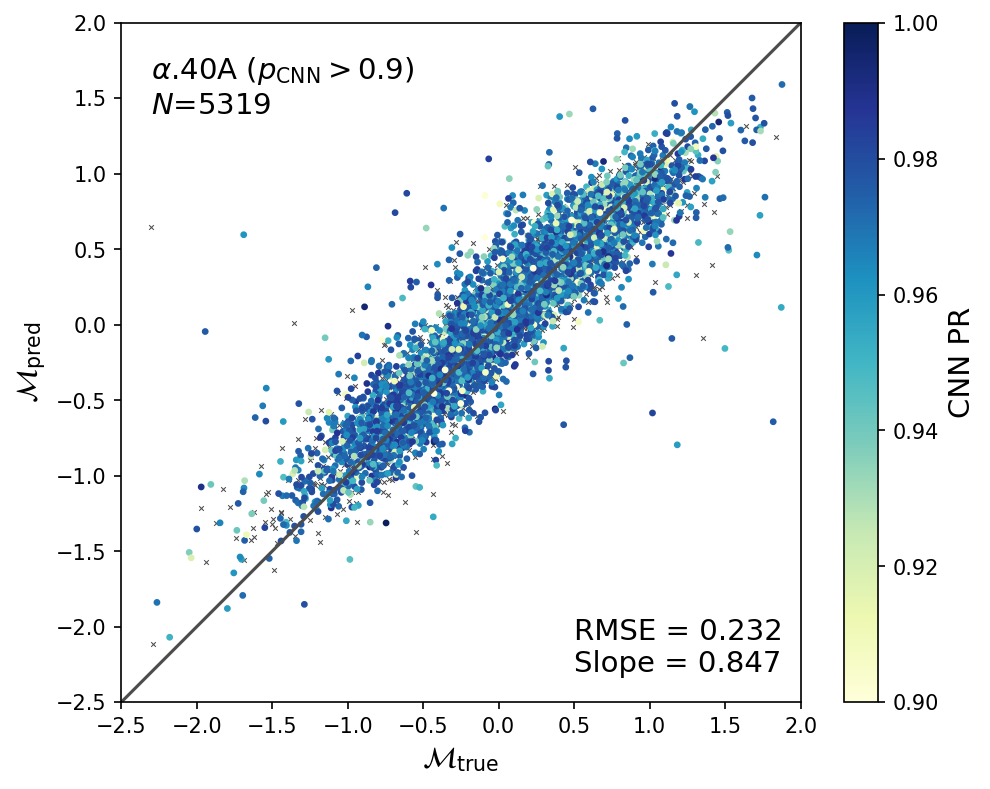

In [200]:
res = a40A
label = r'$\alpha$.40A'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(0.5, -2.3, f'RMSE = {stats[1]:.3f}' + f'\nSlope = {stats[2]:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


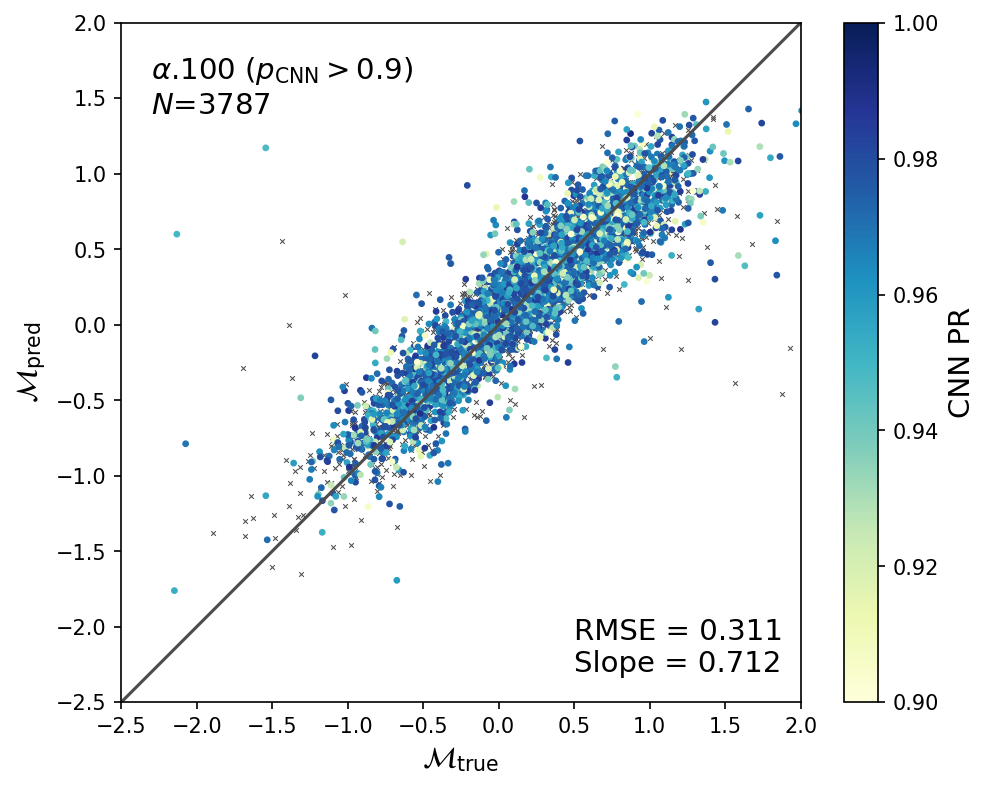

In [201]:
res = a100
label = r'$\alpha$.100'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(0.5, -2.3, f'RMSE = {stats[1]:.3f}' + f'\nSlope = {stats[2]:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


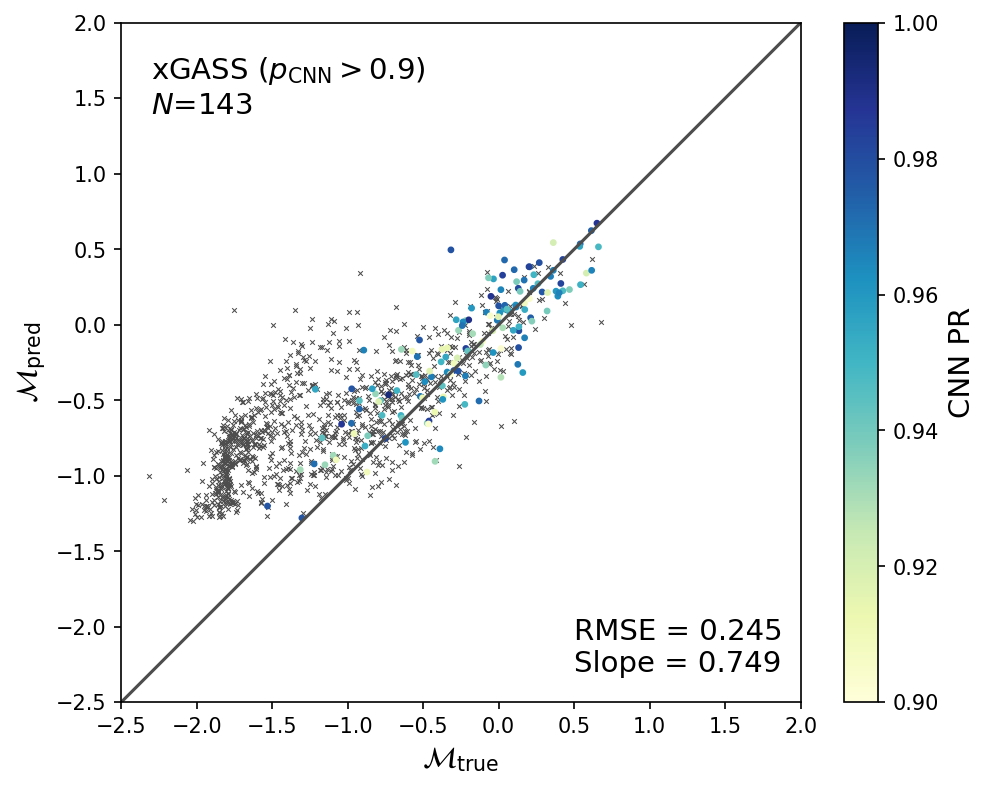

In [202]:
res = xg
label = r'xGASS'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(0.5, -2.3, f'RMSE = {stats[1]:.3f}' + f'\nSlope = {stats[2]:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


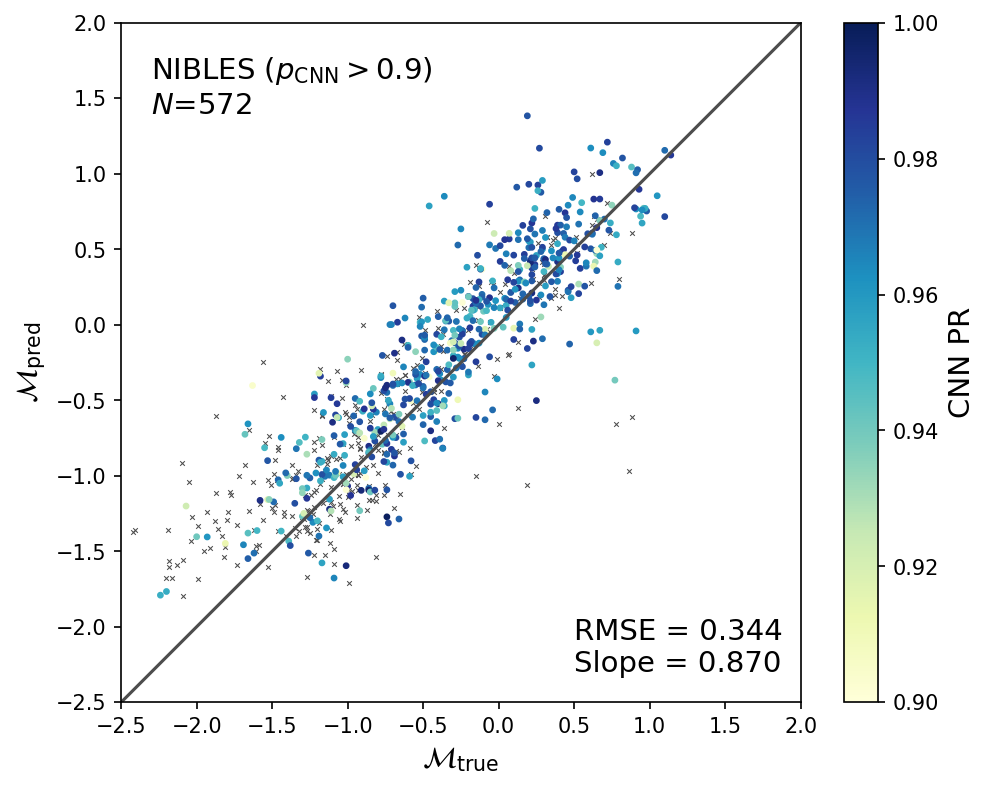

In [203]:
res = nib
label = r'NIBLES'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(0.5, -2.3, f'RMSE = {stats[1]:.3f}' + f'\nSlope = {stats[2]:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


## $p_{\rm CNN} > 0.9$ | $\sigma$ + offset

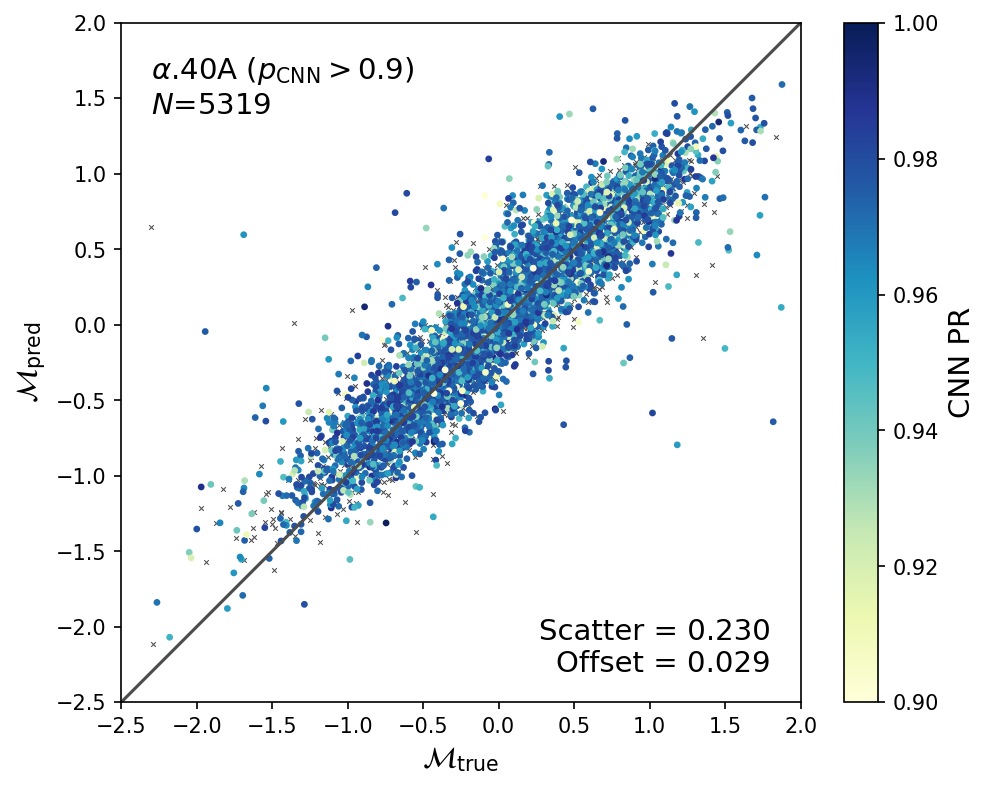

In [204]:
res = a40A
label = r'$\alpha$.40A'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(1.8, -2.3, f'Scatter = {stats[3]:.3f}' + f'\nOffset = {stats[4]:.3f}', fontsize=14, ha='right')

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


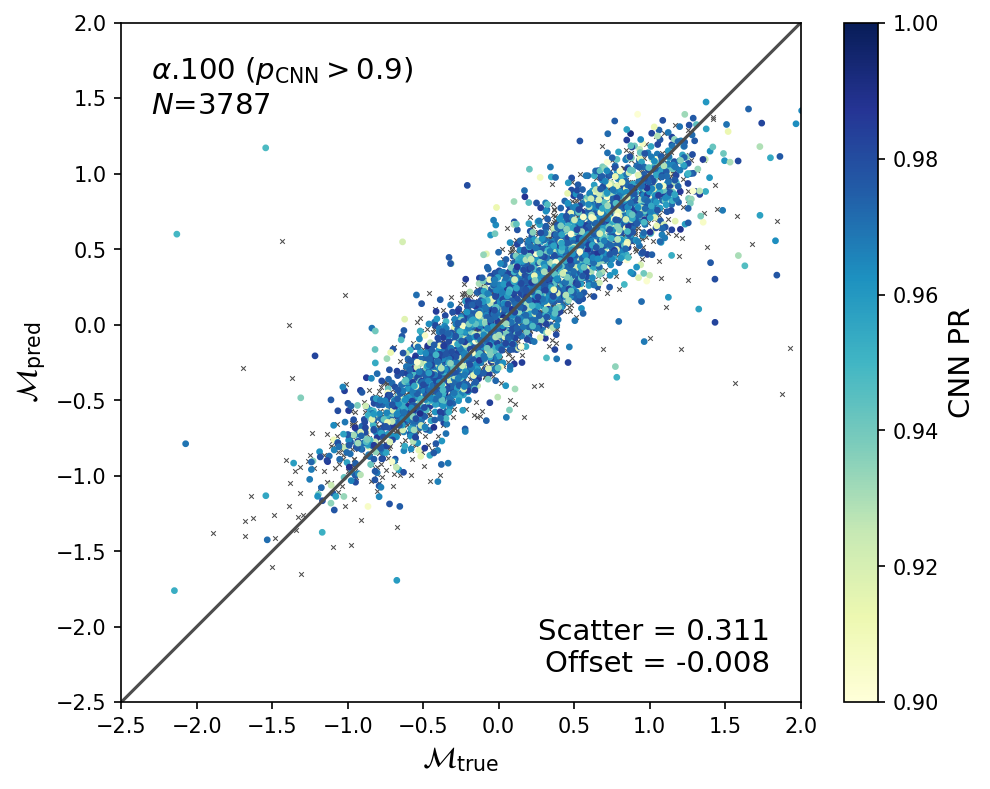

In [205]:
res = a100
label = r'$\alpha$.100'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(1.8, -2.3, f'Scatter = {stats[3]:.3f}' + f'\nOffset = {stats[4]:.3f}', fontsize=14, ha='right')

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


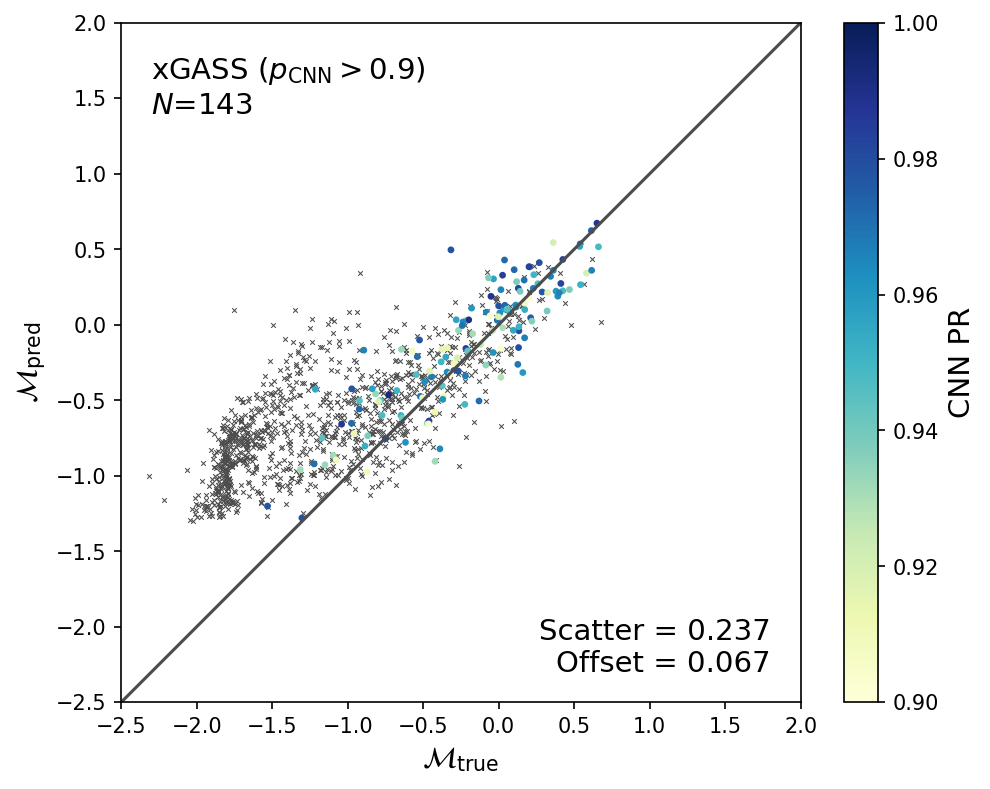

In [206]:
res = xg
label = r'xGASS'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(1.8, -2.3, f'Scatter = {stats[3]:.3f}' + f'\nOffset = {stats[4]:.3f}', fontsize=14, ha='right')

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


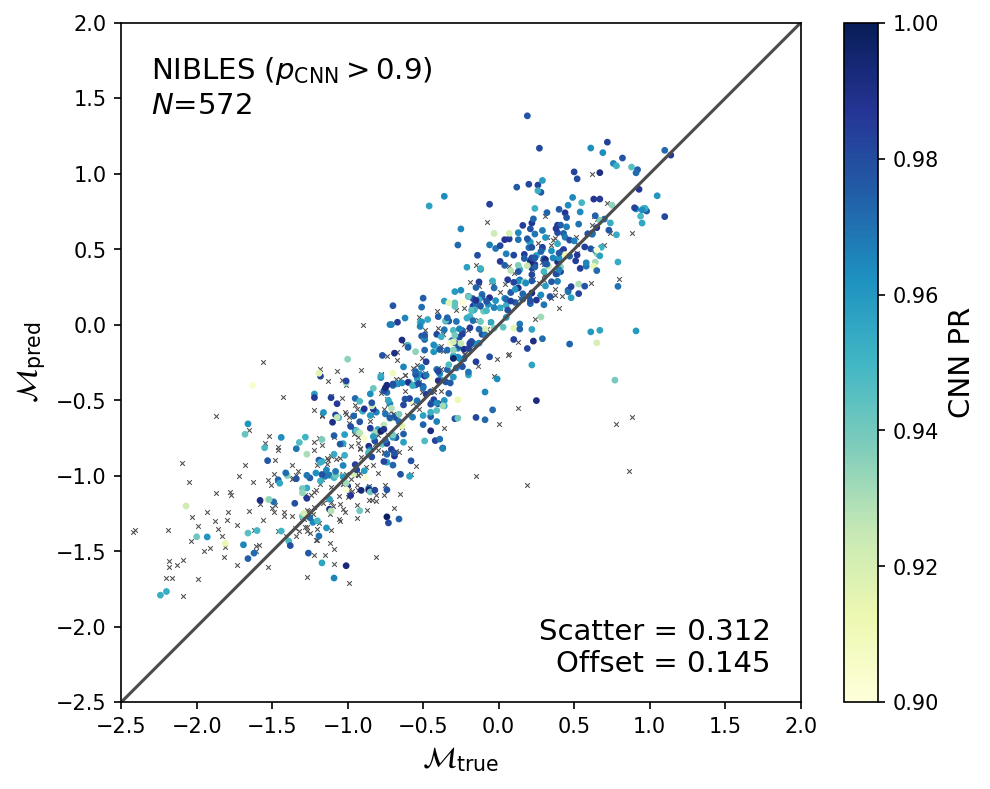

In [207]:
res = nib
label = r'NIBLES'

# recall that `stats` are [N, RMSE, slope, stdev, offset]
PR_accept = res.p_CNN > p
stats = summary_stats(res.fgas_pred, res.fgas_true, PR_accept) 

plt.figure(figsize=(7.5, 6), dpi=150)

plt.scatter(res[~PR_accept].fgas_true, res[~PR_accept].fgas_pred, marker='x', lw=0.5, c='0.3', s=5)
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, c=res[PR_accept].p_CNN, s=5, vmin=p, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {stats[0]}', fontsize=14)
plt.text(1.8, -2.3, f'Scatter = {stats[3]:.3f}' + f'\nOffset = {stats[4]:.3f}', fontsize=14, ha='right')

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14);


## List of results

In [218]:
print('     \t N    \tRMSE \tslope  \tstd \toffset')


p = 0
print('\np > 0')
print('=====')

for res, name in zip([a40A, a100, nib, xg], ['a.40A', 'a.100', 'NIBLES', 'xGASS']):
    print(name + '\t' + '\t'.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(res.fgas_pred, res.fgas_true, res.p_CNN > p)
    )))))
    
p = 0.5
print('\np > 0.5')
print('=======')

for res, name in zip([a40A, a100, nib, xg], ['a.40A', 'a.100', 'NIBLES', 'xGASS']):
    print(name + '\t' + '\t'.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(res.fgas_pred, res.fgas_true, res.p_CNN > p)
    )))))
    
p = 0.8
print('\np > 0.8')
print('=======')

for res, name in zip([a40A, a100, nib, xg], ['a.40A', 'a.100', 'NIBLES', 'xGASS']):
    print(name + '\t' + '\t'.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(res.fgas_pred, res.fgas_true, res.p_CNN > p)
    )))))
    
p = 0.9
print('\np > 0.9')
print('=======')

for res, name in zip([a40A, a100, nib, xg], ['a.40A', 'a.100', 'NIBLES', 'xGASS']):
    print(name + '\t' + '\t'.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(res.fgas_pred, res.fgas_true, res.p_CNN > p)
    )))))

     	 N    	RMSE 	slope  	std 	offset

p > 0
=====
a.40A	7128	0.2335	0.8427	0.2318	0.0285
a.100	6087	0.2975	0.7325	0.2974	-0.0076
NIBLES	899	0.3705	0.8395	0.3416	0.1438
xGASS	1179	0.6254	0.4724	0.4284	0.4558

p > 0.5
a.40A	6674	0.232	0.8429	0.2302	0.0291
a.100	5249	0.3043	0.7192	0.3042	-0.0086
NIBLES	767	0.3566	0.8518	0.3238	0.1499
xGASS	326	0.3237	0.6423	0.2962	0.1314

p > 0.8
a.40A	6004	0.2334	0.8434	0.2316	0.0293
a.100	4454	0.3123	0.7084	0.3122	-0.0077
NIBLES	663	0.3508	0.8586	0.317	0.1506
xGASS	217	0.2755	0.6882	0.2669	0.0706

p > 0.9
a.40A	5319	0.2322	0.8468	0.2304	0.029
a.100	3787	0.3107	0.7116	0.3107	-0.0085
NIBLES	572	0.3435	0.8703	0.3116	0.1451
xGASS	143	0.2449	0.7486	0.2365	0.0667


# Crossmatch with Teimoorinia+17, show all results

In [219]:
try:
    t17_coords = SkyCoord(t17.RAJ2000, t17.DEJ2000, unit=u.deg)
except NameError:
    t17 = astropy.io.ascii.read(f'{PATH}/data/Teimoorinia+17.csv').to_pandas().loc[2:]

    t17 = t17.astype(
        {
            'SDSS': np.int64, 'RAJ2000': float, 'DEJ2000': float, 'z': float, 
            'logM*': float, 'logMHI/M*': float, 'Cfgas': float, 'PR': float,
            'sigmafitN': float, 'sigmafit': float, 'sigmafgas': float, 'Sloan': str
        }
    )
    t17_coords = SkyCoord(t17.RAJ2000, t17.DEJ2000, unit=u.deg)

## Perform 1" crossmatches

In [226]:
a40A_coords = SkyCoord(a40A.RAdeg_OC, a40A.DECdeg_OC, unit=u.deg)

# search
cutoff = 1*u.arcsec
idx_t17, idx_a40A, _, _ = a40A_coords.search_around_sky(t17_coords, cutoff)

# crossmatching join
t17_x_a40A = t17.iloc[idx_t17]
a40A_x_t17 = a40A.iloc[idx_a40A]
a40A_x_t17.reset_index(drop=True, inplace=True)
t17_x_a40A.reset_index(inplace=True)
t17_x_a40A = t17_x_a40A.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)
a40A_x_t17 = a40A_x_t17.join(t17_x_a40A, rsuffix='_T17')

a40A_x_t17.to_csv(f'{PATH}/results/final/a40A_x_T17.csv', index='AGCNr')

In [227]:
a100_coords = SkyCoord(a100.RAdeg_OC, a100.DECdeg_OC, unit=u.deg)

# search
cutoff = 1*u.arcsec
idx_t17, idx_a100, _, _ = a100_coords.search_around_sky(t17_coords, cutoff)

# crossmatching join
t17_x_a100 = t17.iloc[idx_t17]
a100_x_t17 = a100.iloc[idx_a100]
a100_x_t17.reset_index(drop=True, inplace=True)
t17_x_a100.reset_index(inplace=True)
t17_x_a100 = t17_x_a100.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)
a100_x_t17 = a100_x_t17.join(t17_x_a100, rsuffix='_T17')

a100_x_t17.to_csv(f'{PATH}/results/final/a100_x_T17.csv', index='AGCNr')

In [231]:
xg_coords = SkyCoord(xg.RA, xg.DEC, unit=u.deg)

# search
cutoff = 1*u.arcsec
idx_t17, idx_xg, _, _ = xg_coords.search_around_sky(t17_coords, cutoff)

# crossmatching join
t17_x_xg = t17.iloc[idx_t17]
xg_x_t17 = xg.iloc[idx_xg]
xg_x_t17.reset_index(drop=True, inplace=True)
t17_x_xg.reset_index(inplace=True)
t17_x_xg = t17_x_xg.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)
xg_x_t17 = xg_x_t17.join(t17_x_xg, rsuffix='_T17')

xg_x_t17.to_csv(f'{PATH}/results/final/xgass_x_T17.csv', index='AGCNr')

In [233]:
nib_coords = SkyCoord(nib.ra, nib.dec, unit=u.deg)

# search
cutoff = 1*u.arcsec
idx_t17, idx_nib, _, _ = nib_coords.search_around_sky(t17_coords, cutoff)

# crossmatching join
t17_x_nib = t17.iloc[idx_t17]
nib_x_t17 = nib.iloc[idx_nib]
nib_x_t17.reset_index(drop=True, inplace=True)
t17_x_nib.reset_index(inplace=True)
t17_x_nib = t17_x_nib.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)
nib_x_t17 = nib_x_t17.join(t17_x_nib, rsuffix='_T17')

nib_x_t17.to_csv(f'{PATH}/results/final/nibles_x_T17.csv', index='AGCNr')

## Get list of CNN results

In [238]:
print('                CROSSMATCHED WITH T17')
print('     \t N    \tRMSE \tslope  \tstd \toffset')

for p in [0, 0.5, 0.8, 0.9]:
    print('\np > ' + f'{p:.1f}')
    print('=======')

    for res, name in zip([a40A_x_t17, a100_x_t17, nib_x_t17, xg_x_t17], ['a.40A', 'a.100', 'NIBLES', 'xGASS']):
        print(name + '\t' + '\t'.join(list(map(str, map(
            partial(np.round, decimals=4), 
            summary_stats(res.fgas_pred, res.fgas_true, res.p_CNN > p)
        )))))
    

                CROSSMATCHED WITH T17
     	 N    	RMSE 	slope  	std 	offset

p > 0.0
a.40A	4798	0.1967	0.8524	0.1953	0.0238
a.100	5124	0.1975	0.8462	0.1971	0.0125
NIBLES	158	0.2988	0.789	0.2791	0.109
xGASS	1012	0.6338	0.4584	0.4258	0.4697

p > 0.5
a.40A	4409	0.1958	0.8531	0.1942	0.0247
a.100	4387	0.1968	0.8473	0.1963	0.0138
NIBLES	137	0.2909	0.7898	0.2739	0.1009
xGASS	262	0.3235	0.6221	0.2953	0.1333

p > 0.8
a.40A	3823	0.1938	0.8574	0.1922	0.025
a.100	3694	0.198	0.844	0.1974	0.016
NIBLES	116	0.2869	0.7981	0.276	0.0826
xGASS	168	0.2645	0.6602	0.2568	0.0665

p > 0.9
a.40A	3263	0.1944	0.8589	0.1927	0.0261
a.100	3126	0.2021	0.8405	0.2015	0.016
NIBLES	99	0.2895	0.809	0.2822	0.0706
xGASS	107	0.2216	0.7392	0.2098	0.0742


## Get CNN results using T17 $C_{\rm fgas} > 0.5$

In [239]:
print('                CROSSMATCHED WITH T17')
print('     \t N    \tRMSE \tslope  \tstd \toffset')
print('\nCfgas > ' + f'0.5')
print('===========')

for res, name in zip([a40A_x_t17, a100_x_t17, nib_x_t17, xg_x_t17], ['a.40A', 'a.100', 'NIBLES', 'xGASS']):
    print(name + '\t' + '\t'.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(res.fgas_pred, res.fgas_true, res.Cfgas > 0.5)
    )))))

                CROSSMATCHED WITH T17
     	 N    	RMSE 	slope  	std 	offset

Cfgas > 0.5
a.40A	3399	0.1869	0.8306	0.1863	0.0157
a.100	3598	0.1838	0.8344	0.1837	0.0063
NIBLES	103	0.2876	0.7507	0.2692	0.1044
xGASS	203	0.2317	0.7138	0.2189	0.0777


## Get T17 results using both version of PR

In [243]:
print('                T17 results (CNN PR)')
print('     \t N    \tRMSE \tslope  \tstd \toffset')

for p in [0, 0.5, 0.8, 0.9]:
    print('\np > ' + f'{p:.1f}')
    print('=======')

    for res, name in zip([a40A_x_t17, a100_x_t17, nib_x_t17, xg_x_t17], ['a.40A', 'a.100', 'NIBLES', 'xGASS']):
        print(name + '\t' + '\t'.join(list(map(str, map(
            partial(np.round, decimals=4), 
            summary_stats(res.fgas_t17, res.fgas_true, res.p_CNN > p)
        )))))
    
print('')    
print('                T17 results (T17 PR)')
print('     \t N    \tRMSE \tslope  \tstd \toffset')
print('\nCfgas > ' + f'0.5')
print('===========')

for res, name in zip([a40A_x_t17, a100_x_t17, nib_x_t17, xg_x_t17], ['a.40A', 'a.100', 'NIBLES', 'xGASS']):
    print(name + '\t' + '\t'.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(res.fgas_t17, res.fgas_true, res.Cfgas > 0.5)
    )))))

                T17 results (CNN PR)
     	 N    	RMSE 	slope  	std 	offset

p > 0.0
a.40A	4798	0.2637	0.8317	0.2556	-0.0647
a.100	5124	0.2688	0.8243	0.2574	-0.0775
NIBLES	158	0.3622	0.7194	0.3474	0.106
xGASS	1012	0.6751	0.4098	0.4793	0.4758

p > 0.5
a.40A	4409	0.2626	0.8297	0.2548	-0.0636
a.100	4387	0.266	0.8267	0.255	-0.0758
NIBLES	137	0.3518	0.7208	0.3435	0.0815
xGASS	262	0.3829	0.5796	0.3649	0.1182

p > 0.8
a.40A	3823	0.2617	0.8343	0.253	-0.0672
a.100	3694	0.2634	0.8263	0.2521	-0.0765
NIBLES	116	0.3252	0.7361	0.3226	0.0509
xGASS	168	0.3185	0.6566	0.3182	0.0283

p > 0.9
a.40A	3263	0.2638	0.834	0.2552	-0.067
a.100	3126	0.2665	0.8239	0.2548	-0.0783
NIBLES	99	0.3167	0.7737	0.3174	0.0234
xGASS	107	0.2826	0.7222	0.2835	0.0145

                T17 results (T17 PR)
     	 N    	RMSE 	slope  	std 	offset

Cfgas > 0.5
a.40A	3399	0.246	0.8179	0.2347	-0.0738
a.100	3598	0.2404	0.8311	0.2243	-0.0867
NIBLES	103	0.3113	0.7734	0.3091	0.0476
xGASS	203	0.2577	0.7127	0.2581	0.0112


## Make bar plots

In [1]:
# using RMSE
CNN_rmse_dict = dict(
    a40A_nocut     = 0.1967,
    a40A_pCNN_0p5  = 0.1958,
    a40A_pCNN_0p8  = 0.1938,
    a40A_pCNN_0p9  = 0.1944,
    a40A_Cfgas_0p5 = 0.1869,
    a100_nocut     = 0.1975,
    a100_pCNN_0p5  = 0.1968,
    a100_pCNN_0p8  = 0.1980,
    a100_pCNN_0p9  = 0.2021,
    a100_Cfgas_0p5 = 0.1838,
    nib_nocut      = 0.2988,
    nib_pCNN_0p5   = 0.2909,
    nib_pCNN_0p8   = 0.2869,
    nib_pCNN_0p9   = 0.2895,
    nib_Cfgas_0p5  = 0.2876,
    xg_nocut       = 0.6338,
    xg_pCNN_0p5    = 0.3235,
    xg_pCNN_0p8    = 0.2645,
    xg_pCNN_0p9    = 0.2216,
    xg_Cfgas_0p5   = 0.2317,
)

T17_rmse_dict = dict(
    a40A_nocut     = 0.2637,
    a40A_pCNN_0p5  = 0.2626,
    a40A_pCNN_0p8  = 0.2617,
    a40A_pCNN_0p9  = 0.2638,
    a40A_Cfgas_0p5 = 0.2460,
    a100_nocut     = 0.2688,
    a100_pCNN_0p5  = 0.2660,
    a100_pCNN_0p8  = 0.2634,
    a100_pCNN_0p9  = 0.2665,
    a100_Cfgas_0p5 = 0.2404,
    nib_nocut      = 0.3622,
    nib_pCNN_0p5   = 0.3518,
    nib_pCNN_0p8   = 0.3252,
    nib_pCNN_0p9   = 0.3167,
    nib_Cfgas_0p5  = 0.3113,
    xg_nocut       = 0.6751,
    xg_pCNN_0p5    = 0.3829,
    xg_pCNN_0p8    = 0.3185,
    xg_pCNN_0p9    = 0.2826,
    xg_Cfgas_0p5   = 0.2577,
)

N_xmatch_dict = dict(
    a40A_nocut     = 4798,
    a40A_pCNN_0p5  = 4409,
    a40A_pCNN_0p8  = 3823,
    a40A_pCNN_0p9  = 3263,
    a40A_Cfgas_0p5 = 3399,
    a100_nocut     = 5124,
    a100_pCNN_0p5  = 4387,
    a100_pCNN_0p8  = 3694,
    a100_pCNN_0p9  = 3126,
    a100_Cfgas_0p5 = 3598,
    nib_nocut      = 158,
    nib_pCNN_0p5   = 137,
    nib_pCNN_0p8   = 116,
    nib_pCNN_0p9   = 99,
    nib_Cfgas_0p5  = 103,
    xg_nocut       = 1012,
    xg_pCNN_0p5    = 262,
    xg_pCNN_0p8    = 168,
    xg_pCNN_0p9    = 107,
    xg_Cfgas_0p5   = 203,
)

In [2]:
results_dict = dict(
    a40A_nocut      = r'no cut',
    a40A_pCNN_0p5   = r'$p_{\rm CNN} > 0.5$',
    a40A_pCNN_0p8   = r'$p_{\rm CNN} > 0.8$',
    a40A_pCNN_0p9   = r'$p_{\rm CNN} > 0.9$',
    a40A_Cfgas_0p5  = r'$C_{\rm fgas} > 0.5$',
    a100_nocut      = r'no cut',
    a100_pCNN_0p5   = r'$p_{\rm CNN} > 0.5$',
    a100_pCNN_0p8   = r'$p_{\rm CNN} > 0.8$',
    a100_pCNN_0p9   = r'$p_{\rm CNN} > 0.9$',
    a100_Cfgas_0p5  = r'$C_{\rm fgas} > 0.5$',
    xg_nocut        = r'no cut',
    xg_pCNN_0p5     = r'$p_{\rm CNN} > 0.5$',
    xg_pCNN_0p8     = r'$p_{\rm CNN} > 0.8$',
    xg_pCNN_0p9     = r'$p_{\rm CNN} > 0.9$',
    xg_Cfgas_0p5    = r'$C_{\rm fgas} > 0.5$',
    nib_nocut       = r'no cut',
    nib_pCNN_0p5    = r'$p_{\rm CNN} > 0.5$',
    nib_pCNN_0p8    = r'$p_{\rm CNN} > 0.8$',
    nib_pCNN_0p9    = r'$p_{\rm CNN} > 0.9$',
    nib_Cfgas_0p5   = r'$C_{\rm fgas} > 0.5$',
)

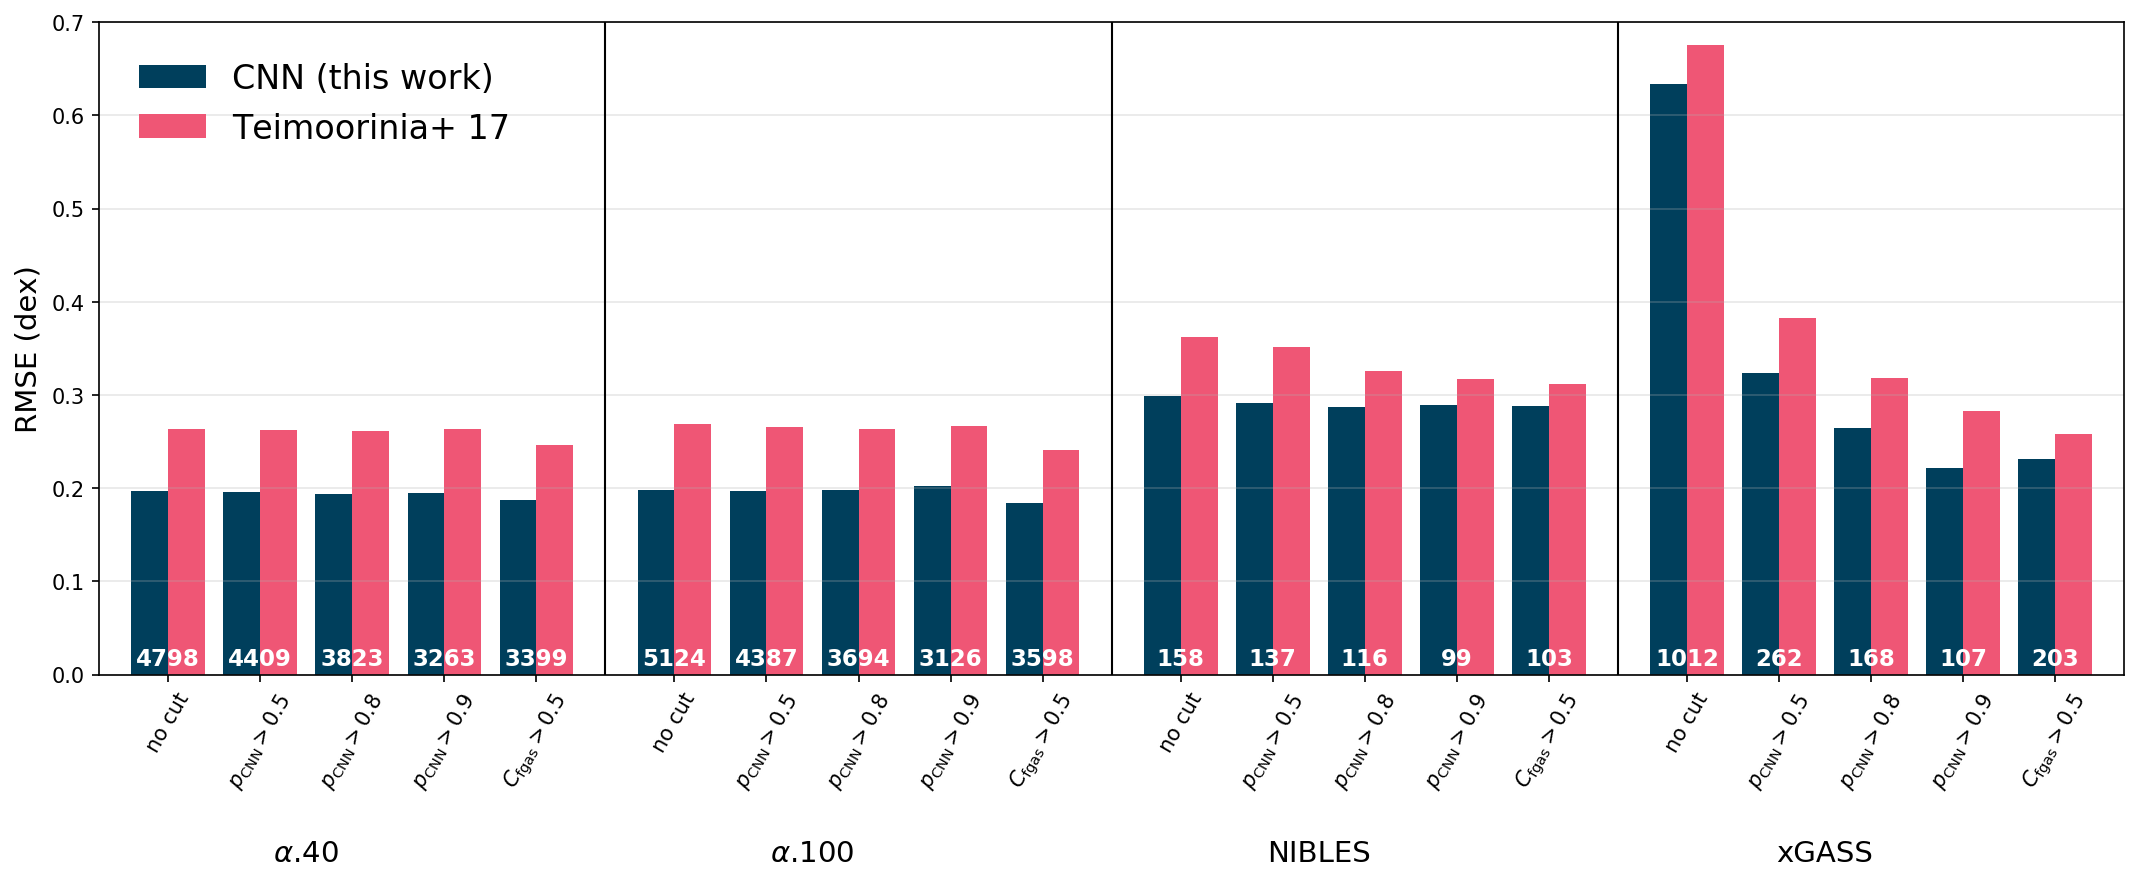

In [335]:
plt.figure(figsize=(15, 6), dpi=150)


X = np.hstack([range(0,5), np.arange(6,11)-0.5, np.arange(11,16), np.arange(17,22)-0.5])

# rmse
plt.bar(
    X-0.2, CNN_rmse_dict.values(), 
    color='#003f5c', width=0.4,
    label='CNN (this work)', 
)

plt.bar(
    X+0.2, T17_rmse_dict.values(), 
    color='#ef5675', width=0.4,
    label='Teimoorinia+ 17', 
)

# sample size
for x, s in zip(X, N_xmatch_dict.values()):
    plt.text(x, 0.01, s, fontsize=11, color='white', ha='center', fontweight='bold')


# separators
plt.axvline(4.75, color='black', lw=1,)
plt.axvline(10.25, color='black', lw=1,)
plt.axvline(15.75, color='black', lw=1,)


plt.legend(loc='upper left', fontsize=16, framealpha=0, labelspacing=0.5, borderaxespad=0.8)

plt.xticks(X, results_dict.values(), rotation=60, horizontalalignment='center')
plt.xlim(-0.75, 21.25)

plt.ylabel('RMSE (dex)', fontsize=14)
plt.ylim(0, 0.7)

# subtitles
plt.text(1.5, -0.2, r'$\alpha$.40', fontsize=14, ha='center')
plt.text(7, -0.2, r'$\alpha$.100', fontsize=14, ha='center')
plt.text(12.5, -0.2, r'NIBLES', fontsize=14, ha='center')
plt.text(18, -0.2, r'xGASS', fontsize=14, ha='center')


plt.grid(axis='y', alpha=0.3)

plt.subplots_adjust(left=0.075, right=0.975, bottom=0.25, top=0.975)

plt.savefig(f'{PATH}/results/final/CNN_x_T17_RMSE_comparison.pdf')

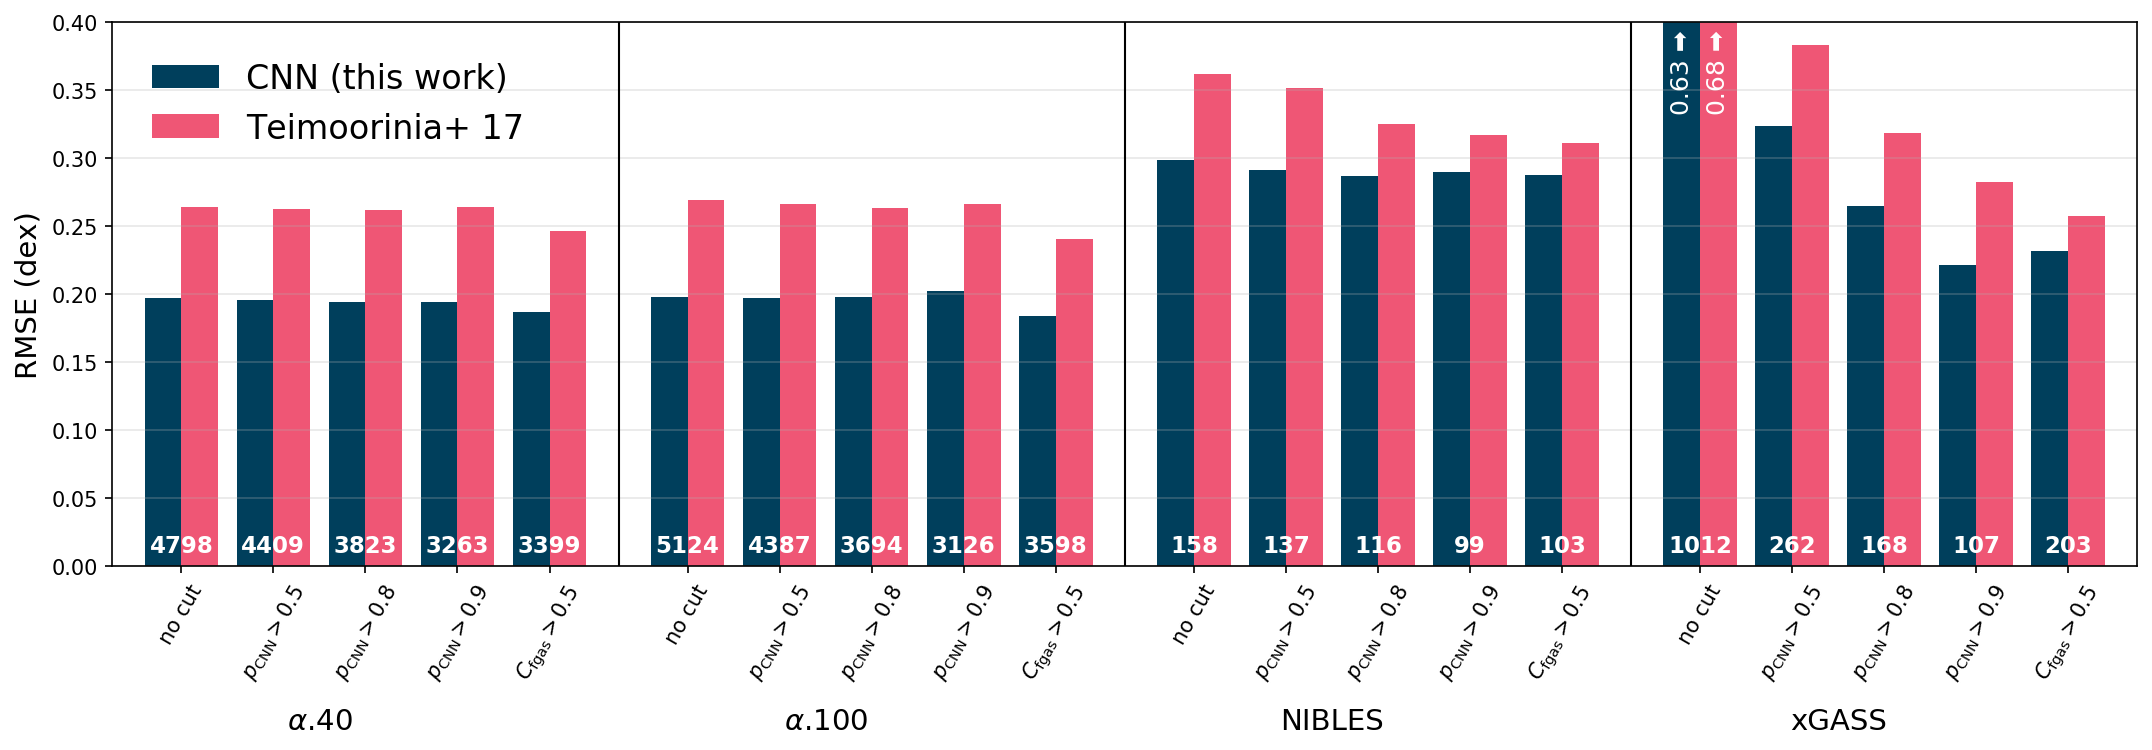

In [337]:
plt.figure(figsize=(15, 5), dpi=150)


X = np.hstack([range(0,5), np.arange(6,11)-0.5, np.arange(11,16), np.arange(17,22)-0.5])

# rmse
plt.bar(
    X-0.2, CNN_rmse_dict.values(), 
    color='#003f5c', width=0.4,
    label='CNN (this work)', 
)

plt.bar(
    X+0.2, T17_rmse_dict.values(), 
    color='#ef5675', width=0.4,
    label='Teimoorinia+ 17', 
)

# sample size
for x, s in zip(X, N_xmatch_dict.values()):
    plt.text(x, 0.01, s, fontsize=11, color='white', ha='center', fontweight='bold')


# separators
plt.axvline(4.75, color='black', lw=1,)
plt.axvline(10.25, color='black', lw=1,)
plt.axvline(15.75, color='black', lw=1,)


plt.legend(loc='upper left', fontsize=16, framealpha=0, labelspacing=0.5, borderaxespad=0.8)

plt.xticks(X, results_dict.values(), rotation=60, horizontalalignment='center')
plt.xlim(-0.75, 21.25)

plt.ylabel('RMSE (dex)', fontsize=14)
plt.ylim(0, 0.4)

# label parts that are cut off
plt.text(16.3, 0.395, f'{CNN_rmse_dict["xg_nocut"]:.2f} ➡️', rotation=90, va='top', ha='center', color='white', fontsize=12)
plt.text(16.7, 0.395, f'{T17_rmse_dict["xg_nocut"]:.2f} ➡️', rotation=90, va='top', ha='center', color='white', fontsize=12)


# subtitles
plt.text(1.5, -0.12, r'$\alpha$.40', fontsize=14, ha='center')
plt.text(7, -0.12, r'$\alpha$.100', fontsize=14, ha='center')
plt.text(12.5, -0.12, r'NIBLES', fontsize=14, ha='center')
plt.text(18, -0.12, r'xGASS', fontsize=14, ha='center')


plt.grid(axis='y', alpha=0.3)

plt.subplots_adjust(left=0.075, right=0.975, bottom=0.25, top=0.975)

plt.savefig(f'{PATH}/results/final/CNN_x_T17_RMSE_comparison-short.pdf')

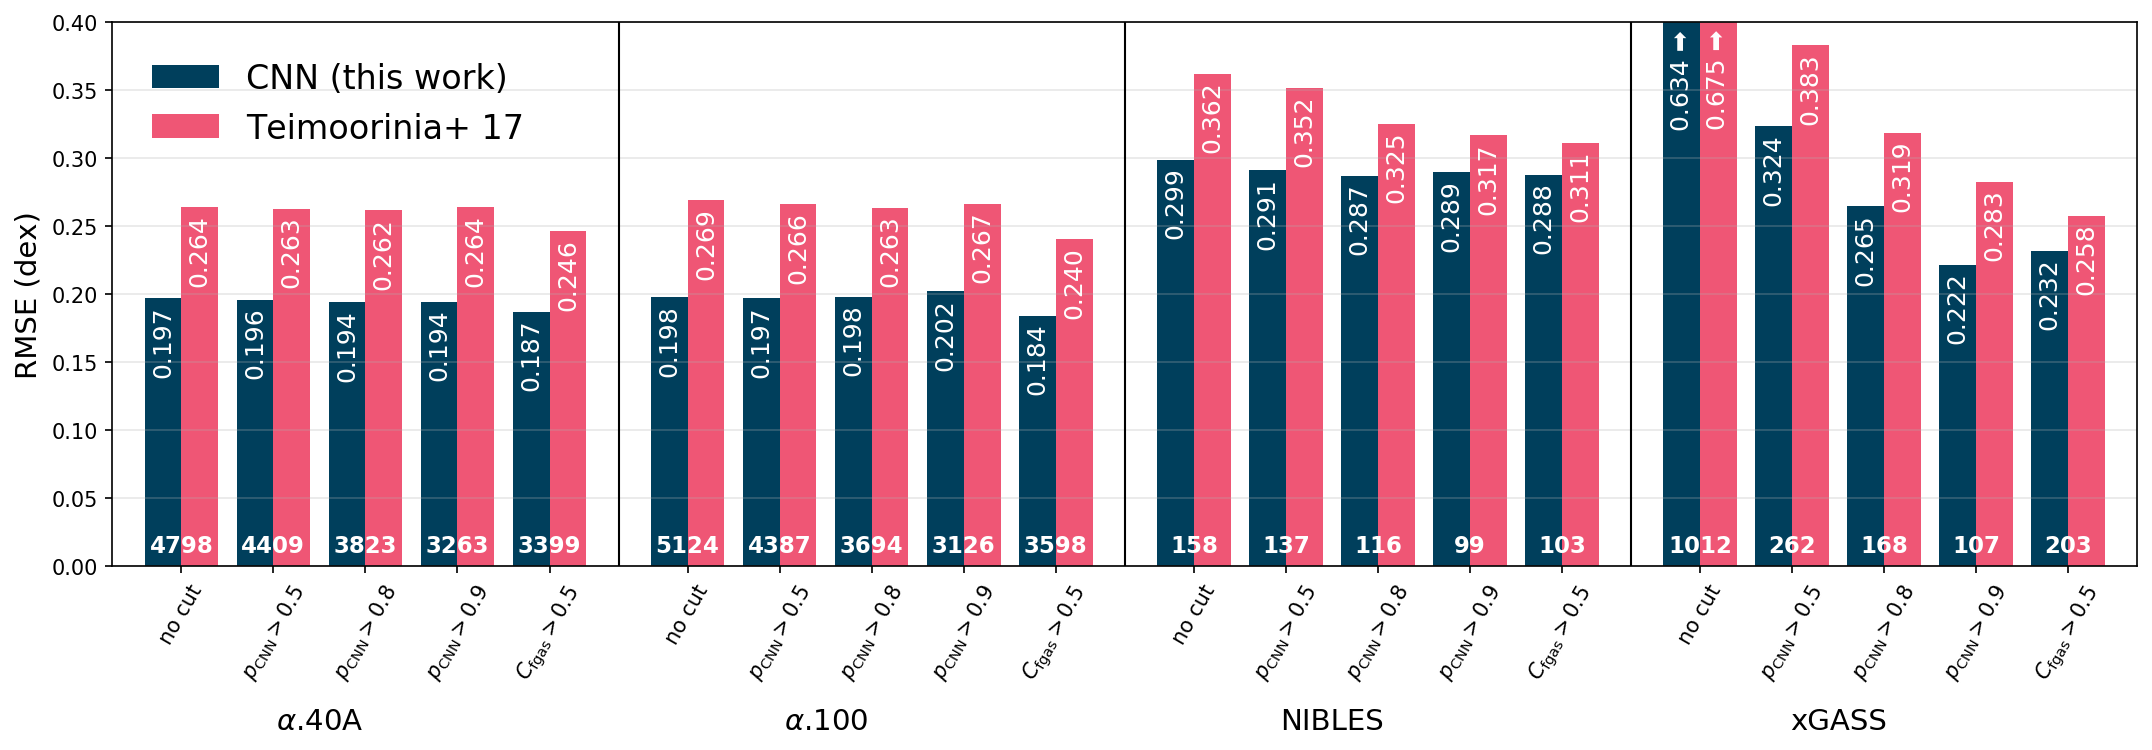

In [339]:
plt.figure(figsize=(15, 5), dpi=150)


X = np.hstack([range(0,5), np.arange(6,11)-0.5, np.arange(11,16), np.arange(17,22)-0.5])

# rmse
plt.bar(
    X-0.2, CNN_rmse_dict.values(), 
    color='#003f5c', width=0.4,
    label='CNN (this work)', 
)

plt.bar(
    X+0.2, T17_rmse_dict.values(), 
    color='#ef5675', width=0.4,
    label='Teimoorinia+ 17', 
)

# sample size
for x, s in zip(X, N_xmatch_dict.values()):
    plt.text(x, 0.01, s, fontsize=11, color='white', ha='center', fontweight='bold')


# separators
plt.axvline(4.75, color='black', lw=1,)
plt.axvline(10.25, color='black', lw=1,)
plt.axvline(15.75, color='black', lw=1,)


plt.legend(loc='upper left', fontsize=16, framealpha=0, labelspacing=0.5, borderaxespad=0.8)

plt.xticks(X, results_dict.values(), rotation=60, horizontalalignment='center')
plt.xlim(-0.75, 21.25)

plt.ylabel('RMSE (dex)', fontsize=14)
plt.ylim(0, 0.4)

# label all
for x, y_CNN, y_T17 in zip(X, CNN_rmse_dict.values(), T17_rmse_dict.values()):
    if y_CNN > 0.4:
        plt.text(x-0.2, 0.395, f'{y_CNN:.3f} ➡️', rotation=90, va='top', ha='center', color='white', fontsize=12)
        plt.text(x+0.2, 0.395, f'{y_T17:.3f} ➡️', rotation=90, va='top', ha='center', color='white', fontsize=12)
    else:
        plt.text(x-0.2, y_CNN-0.005, f'{y_CNN:.3f}', rotation=90, va='top', ha='center', color='white', fontsize=12)
        plt.text(x+0.2, y_T17-0.005, f'{y_T17:.3f}', rotation=90, va='top', ha='center', color='white', fontsize=12)



# subtitles
plt.text(1.5, -0.12, r'$\alpha$.40A', fontsize=14, ha='center')
plt.text(7, -0.12, r'$\alpha$.100', fontsize=14, ha='center')
plt.text(12.5, -0.12, r'NIBLES', fontsize=14, ha='center')
plt.text(18, -0.12, r'xGASS', fontsize=14, ha='center')


plt.grid(axis='y', alpha=0.3)

plt.subplots_adjust(left=0.075, right=0.975, bottom=0.25, top=0.975)

plt.savefig(f'{PATH}/results/final/CNN_x_T17_RMSE_comparison-labeled.pdf')

## Show scatter plots

### $p_{\rm CNN} > 0.5$

In [297]:
p = 0.5

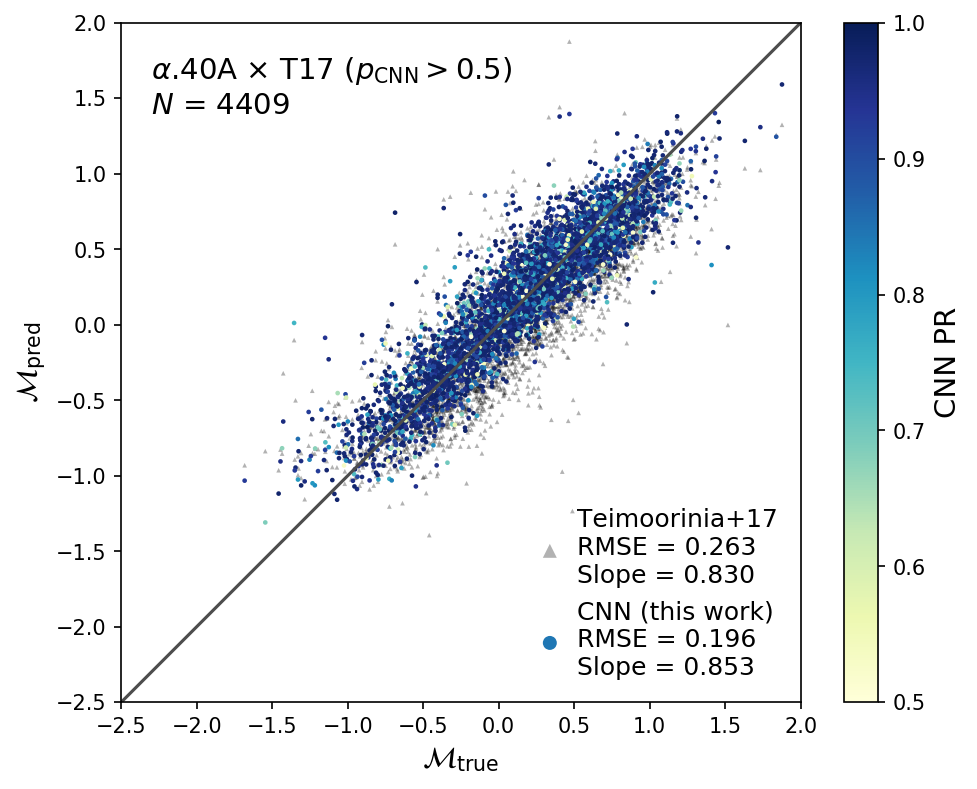

In [306]:
res = a40A_x_t17
label = r'$\alpha$.40A $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.p_CNN > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=5, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c=res[PR_accept].p_CNN, cmap='YlGnBu', s=5, vmin=0.5, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=3, handletextpad=0.1)

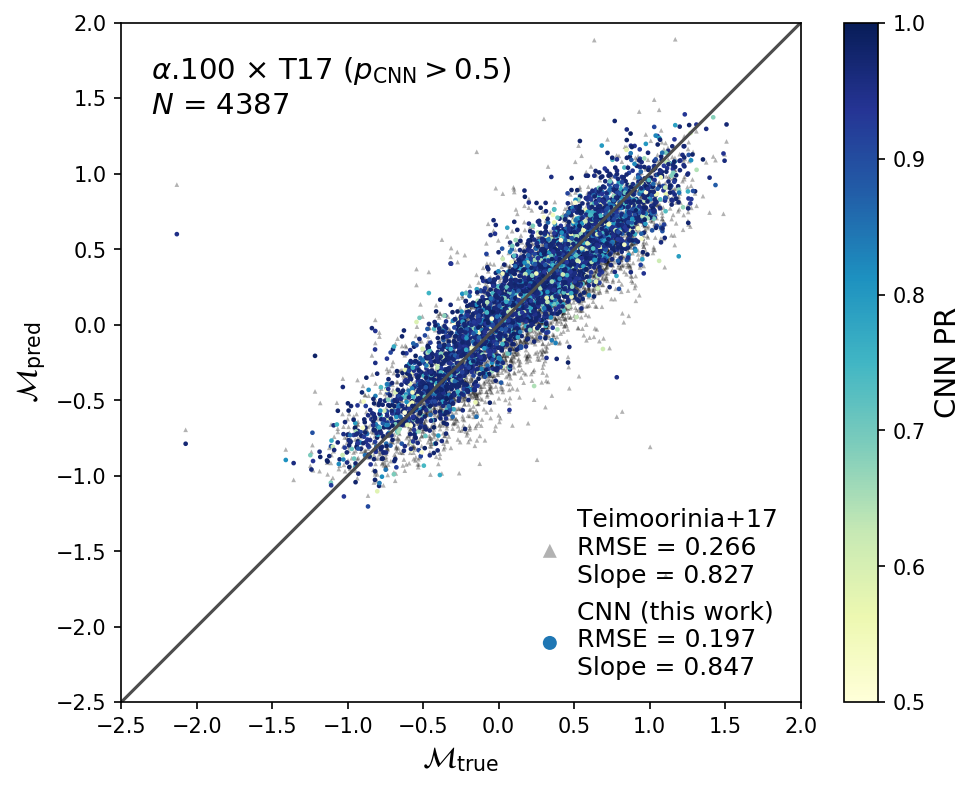

In [307]:
res = a100_x_t17
label = r'$\alpha$.100 $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.p_CNN > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=5, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c=res[PR_accept].p_CNN, cmap='YlGnBu', s=5, vmin=0.5, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=3, handletextpad=0.1)

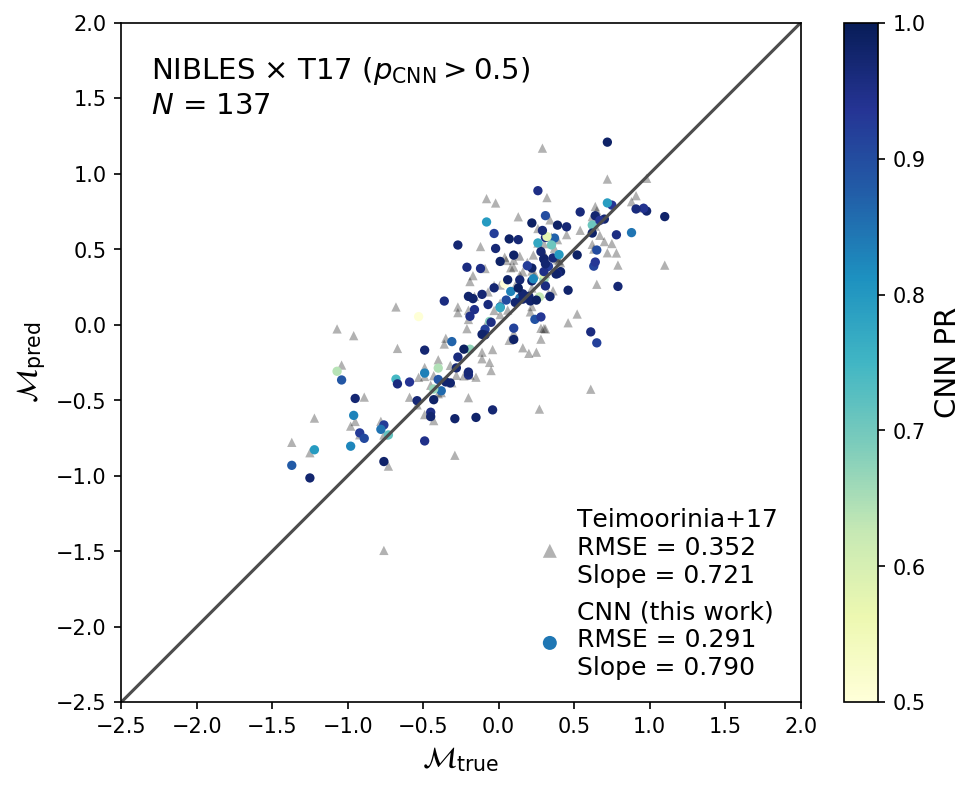

In [312]:
res = nib_x_t17
label = r'NIBLES $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.p_CNN > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=20, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c=res[PR_accept].p_CNN, cmap='YlGnBu', s=20, vmin=0.5, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=1.5, handletextpad=0.1)

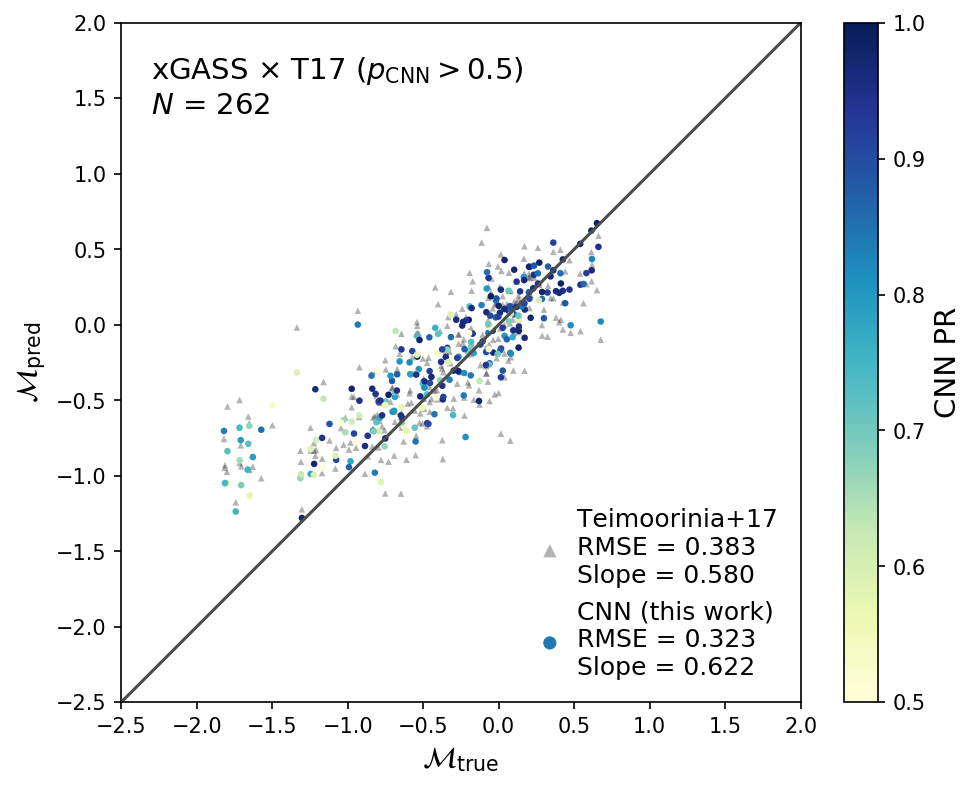

In [313]:
res = xg_x_t17
label = r'xGASS $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.p_CNN > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=10, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c=res[PR_accept].p_CNN, cmap='YlGnBu', s=10, vmin=0.5, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=2, handletextpad=0.1)

### $p_{\rm CNN} > 0.9$

In [316]:
p = 0.9

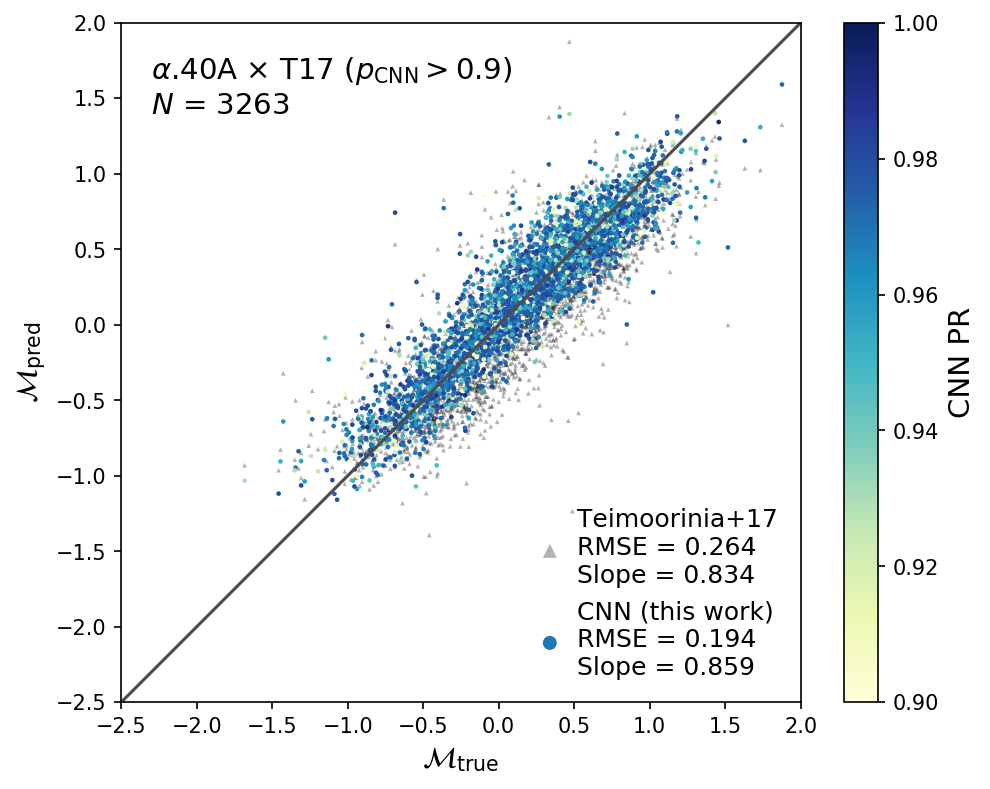

In [317]:
res = a40A_x_t17
label = r'$\alpha$.40A $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.p_CNN > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=5, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c=res[PR_accept].p_CNN, cmap='YlGnBu', s=5, vmin=p, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=3, handletextpad=0.1)

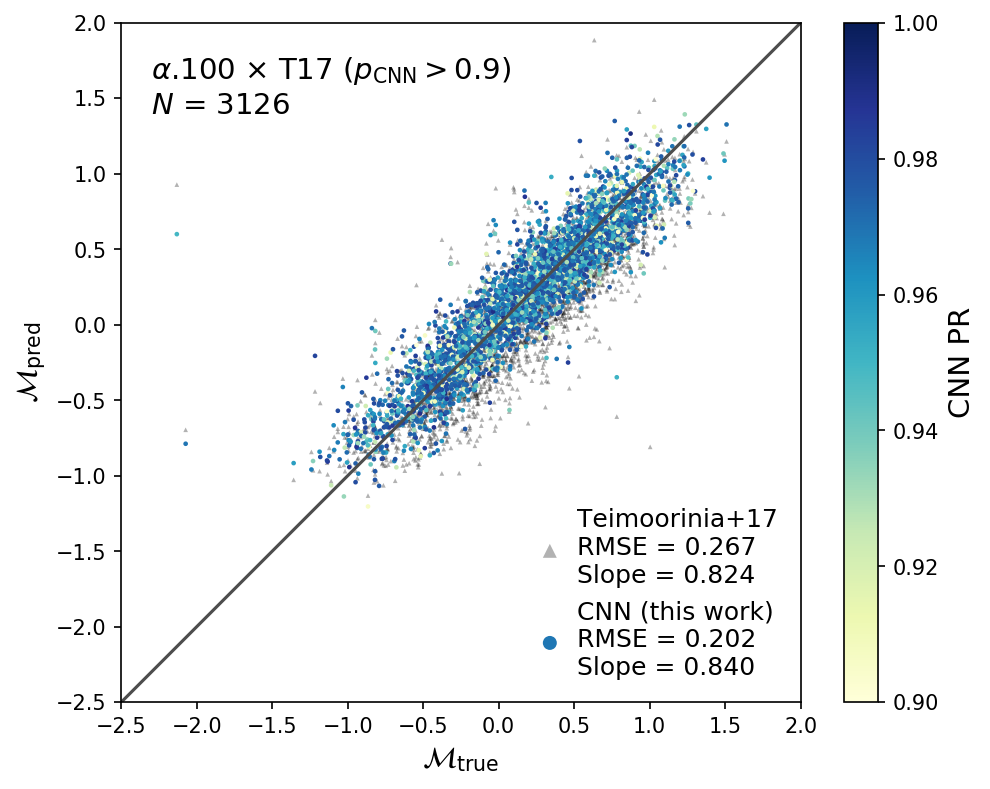

In [318]:
res = a100_x_t17
label = r'$\alpha$.100 $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.p_CNN > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=5, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c=res[PR_accept].p_CNN, cmap='YlGnBu', s=5, vmin=p, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=3, handletextpad=0.1)

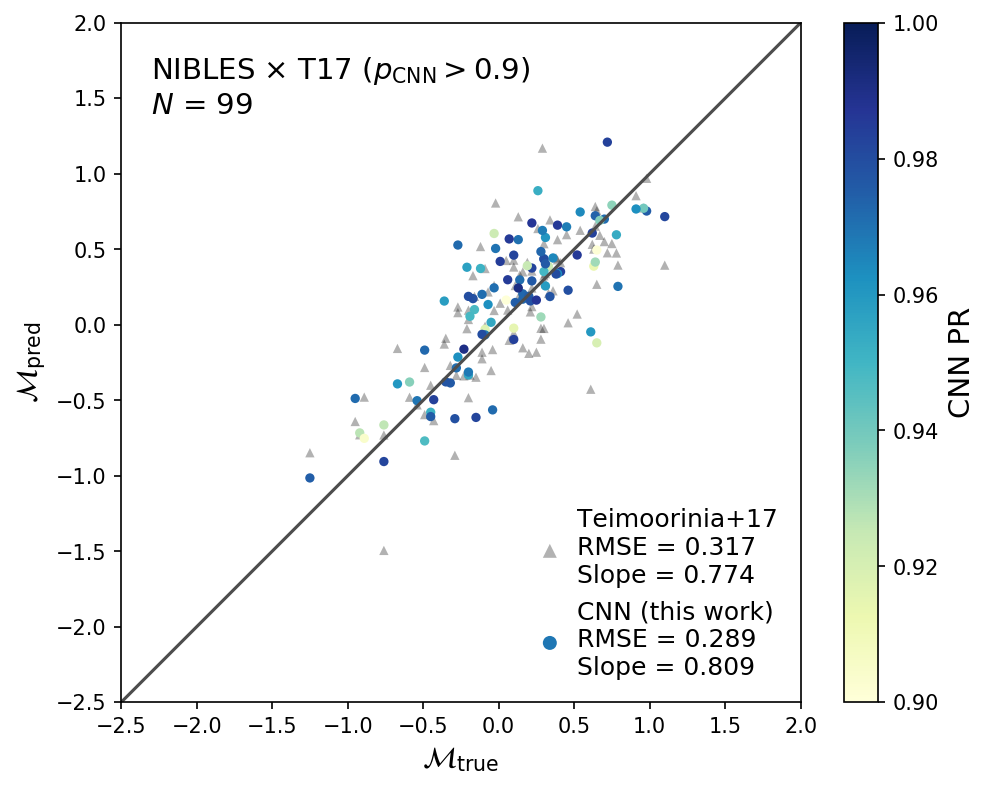

In [319]:
res = nib_x_t17
label = r'NIBLES $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.p_CNN > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=20, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c=res[PR_accept].p_CNN, cmap='YlGnBu', s=20, vmin=p, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=1.5, handletextpad=0.1)

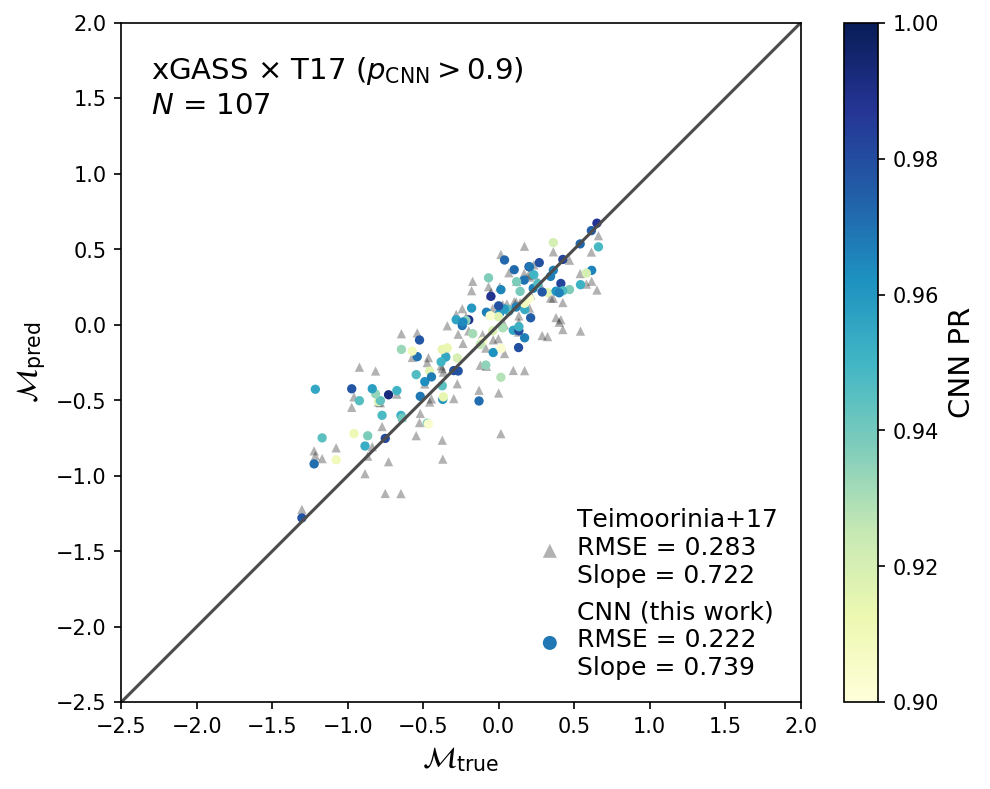

In [321]:
res = xg_x_t17
label = r'xGASS $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.p_CNN > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=20, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c=res[PR_accept].p_CNN, cmap='YlGnBu', s=20, vmin=p, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=1.5, handletextpad=0.1)

### $C_{\rm fgas} > 0.5$

In [322]:
p = 0.5

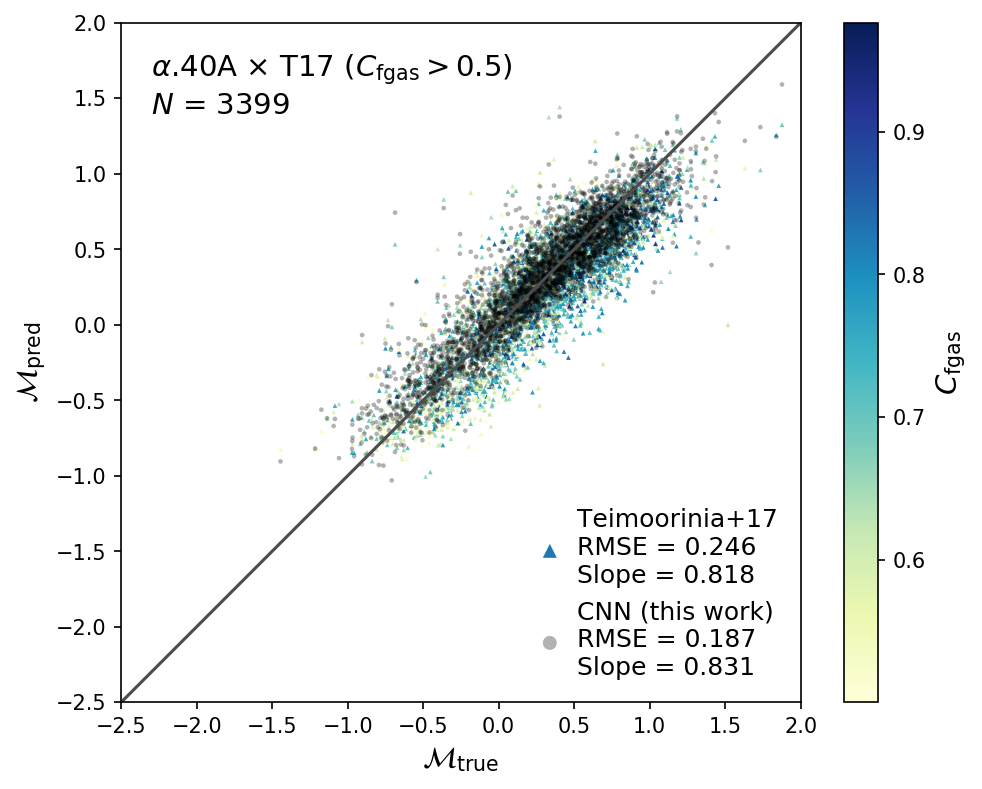

In [332]:
res = a40A_x_t17
label = r'$\alpha$.40A $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.Cfgas > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c=res[PR_accept].Cfgas, edgecolors='none', cmap='YlGnBu', marker='^', s=5, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c='k', alpha=0.3, s=5, vmin=0.5, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($C_{\rm fgas}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=3, handletextpad=0.1)

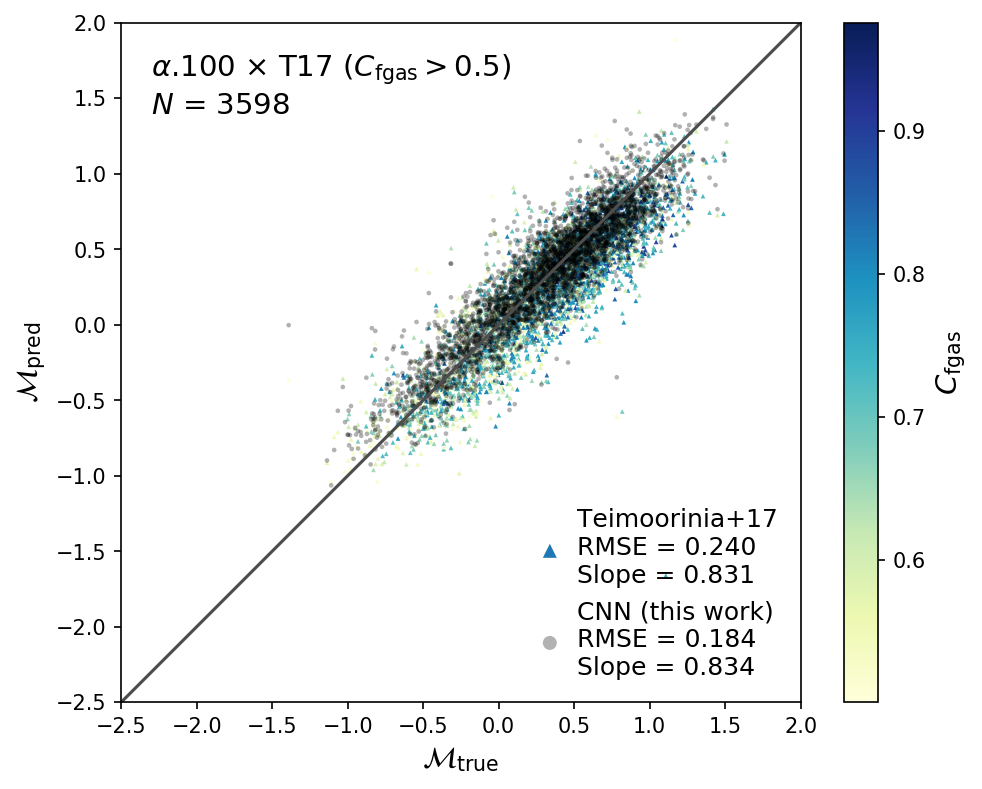

In [331]:
res = a100_x_t17
label = r'$\alpha$.100 $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.Cfgas > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c=res[PR_accept].Cfgas, edgecolors='none', cmap='YlGnBu', marker='^', s=5, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c='k', alpha=0.3, s=5, vmin=0.5, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($C_{\rm fgas}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=3, handletextpad=0.1)

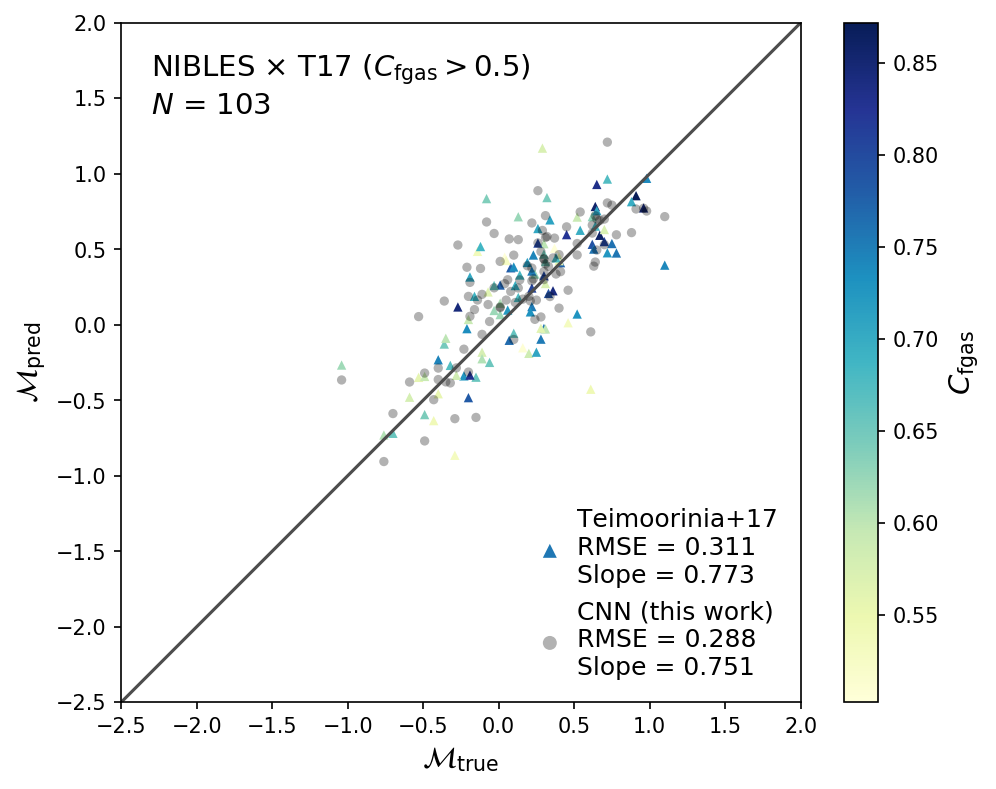

In [330]:
res = nib_x_t17
label = r'NIBLES $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.Cfgas > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c=res[PR_accept].Cfgas, edgecolors='none', cmap='YlGnBu', marker='^', s=20, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c='k', alpha=0.3, s=20, vmin=0.5, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($C_{\rm fgas}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=1.5, handletextpad=0.1)

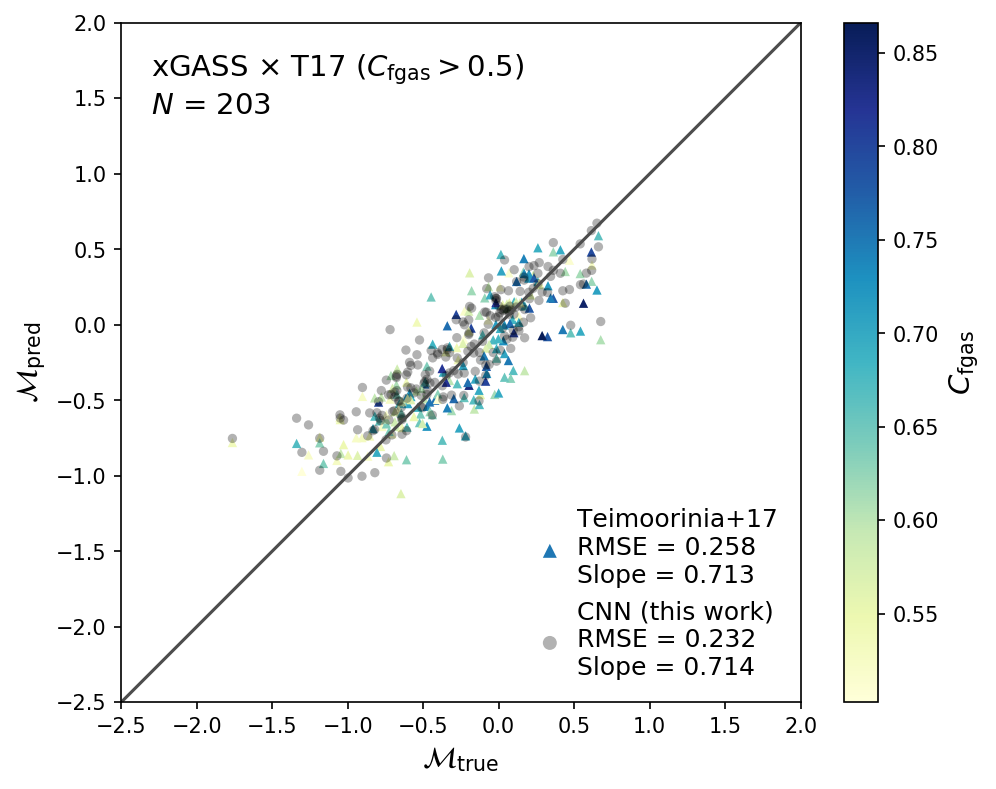

In [329]:
res = xg_x_t17
label = r'xGASS $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.Cfgas > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c=res[PR_accept].Cfgas, edgecolors='none', cmap='YlGnBu', marker='^', s=20, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c='k', alpha=0.3, s=20, vmin=0.5, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($C_{\rm fgas}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=1.5, handletextpad=0.1)

## Alternate scatter plots

In [7]:
a40A_x_t17 = pd.read_csv(f'{PATH}/results/final/a40A_x_T17.csv')
a100_x_t17 = pd.read_csv(f'{PATH}/results/final/a100_x_T17.csv')
nib_x_t17 = pd.read_csv(f'{PATH}/results/final/nibles_x_T17.csv')
xg_x_t17 = pd.read_csv(f'{PATH}/results/final/xgass_x_T17.csv')

### All four using $p_{\rm CNN}$

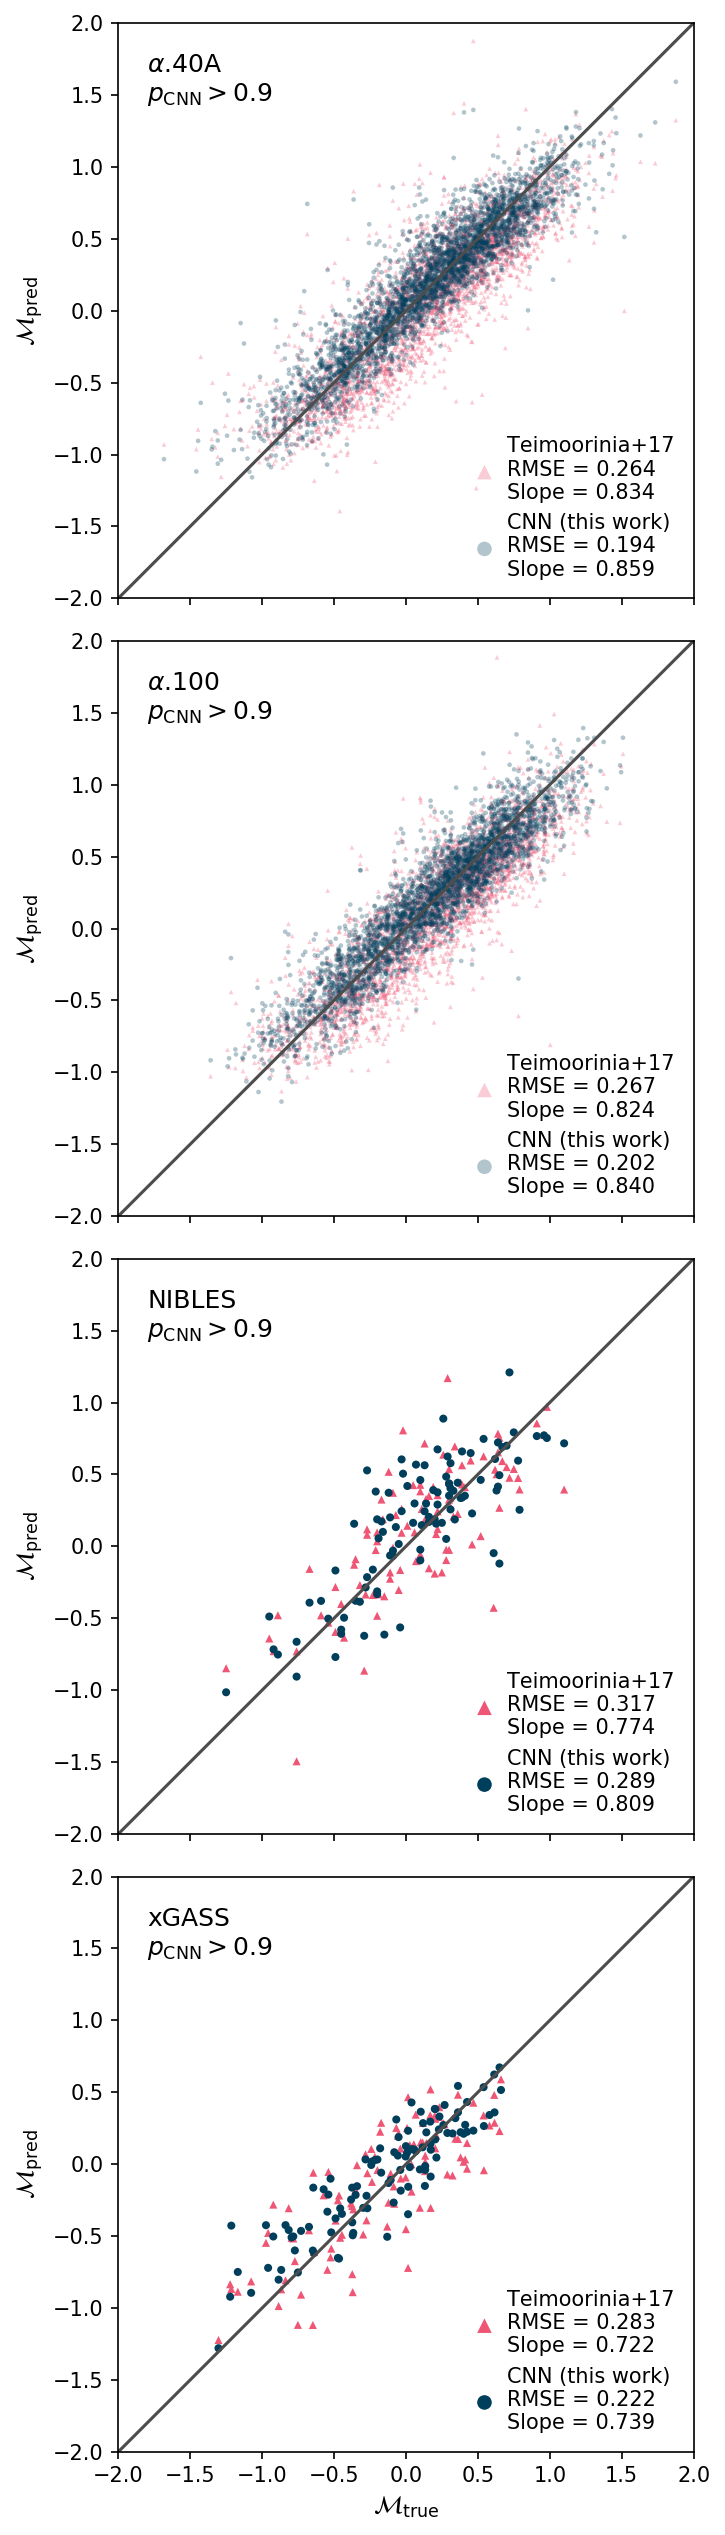

In [29]:
p = 0.9

fig, axes = plt.subplots(4, 1, figsize=(5, 17), dpi=150, sharex=True)

for ax, res, label, alpha, s in zip(
    axes.flat,
    [a40A_x_t17, a100_x_t17, nib_x_t17, xg_x_t17], 
    [r'$\alpha$.40A', r'$\alpha$.100', 'NIBLES', 'xGASS'],
    [0.3, 0.3, 1, 1],
    [5, 5, 15, 15],
):
    
    # get stats
    PR_accept = res.p_CNN > p
    N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
    _, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

    ax.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='#ef5675', edgecolors='none', alpha=alpha, marker='^', s=s, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
    ax.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c='#003f5c', s=s, alpha=alpha, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')

    ax.plot([-2.5, 2], [-2.5, 2], c='0.3')
    ax.set_aspect('equal')
    ax.set_xlim(-2., 2)
    ax.set_ylim(-2., 2)
    
    ax.legend(loc='lower right', fontsize=10, framealpha=0, markerscale=7/s**0.5, handletextpad=0.1)
    ax.text(0.05, 0.9, label + '\n' + r'$p_{\rm CNN}>$' f'{p:.1f}', fontsize=12, ha='left', va='center', transform=ax.transAxes)
    ax.set_ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)
    
axes[-1].set_xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
axes[-1].set_xticks(np.arange(-2,2.5,0.5))    

fig.tight_layout()
fig.savefig(f'{PATH}/results/final/CNN_x_T17-scatterplots_combined-pCNN0.9.pdf')

### All four using $C_{\rm fgas}$

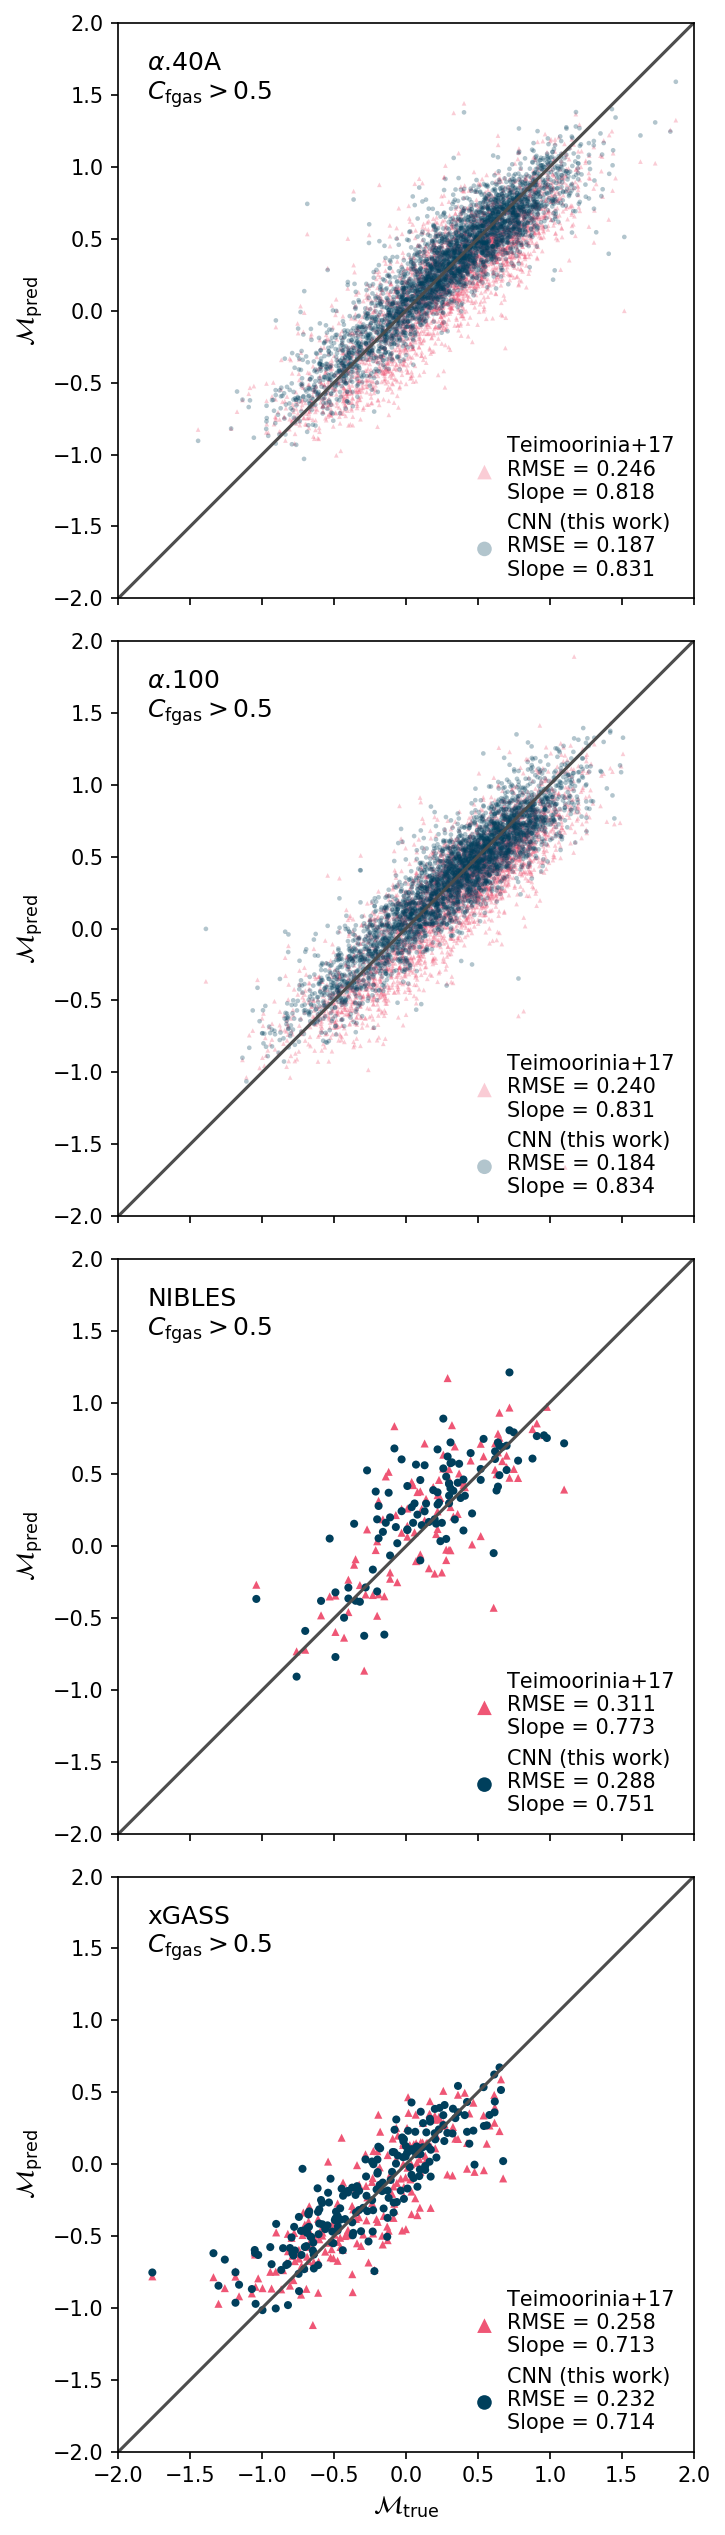

In [31]:
p = 0.5 # Cfgas

fig, axes = plt.subplots(4, 1, figsize=(5, 17), dpi=150, sharex=True)

for ax, res, label, alpha, s in zip(
    axes.flat,
    [a40A_x_t17, a100_x_t17, nib_x_t17, xg_x_t17], 
    [r'$\alpha$.40A', r'$\alpha$.100', 'NIBLES', 'xGASS'],
    [0.3, 0.3, 1, 1],
    [5, 5, 15, 15],
):
    
    # get stats
    PR_accept = res.Cfgas > p
    N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
    _, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

    ax.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='#ef5675', edgecolors='none', alpha=alpha, marker='^', s=s, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
    ax.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c='#003f5c', s=s, alpha=alpha, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')

    ax.plot([-2.5, 2], [-2.5, 2], c='0.3')
    ax.set_aspect('equal')
    ax.set_xlim(-2., 2)
    ax.set_ylim(-2., 2)
    
    ax.legend(loc='lower right', fontsize=10, framealpha=0, markerscale=7/s**0.5, handletextpad=0.1)
    ax.text(0.05, 0.9, label + '\n' + r'$C_{\rm fgas}>$' f'{p:.1f}', fontsize=12, ha='left', va='center', transform=ax.transAxes)
    ax.set_ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)
    
axes[-1].set_xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
axes[-1].set_xticks(np.arange(-2,2.5,0.5))    

fig.tight_layout()
fig.savefig(f'{PATH}/results/final/CNN_x_T17-scatterplots_combined-Cfgas.pdf')

### Three test sets using both PRs

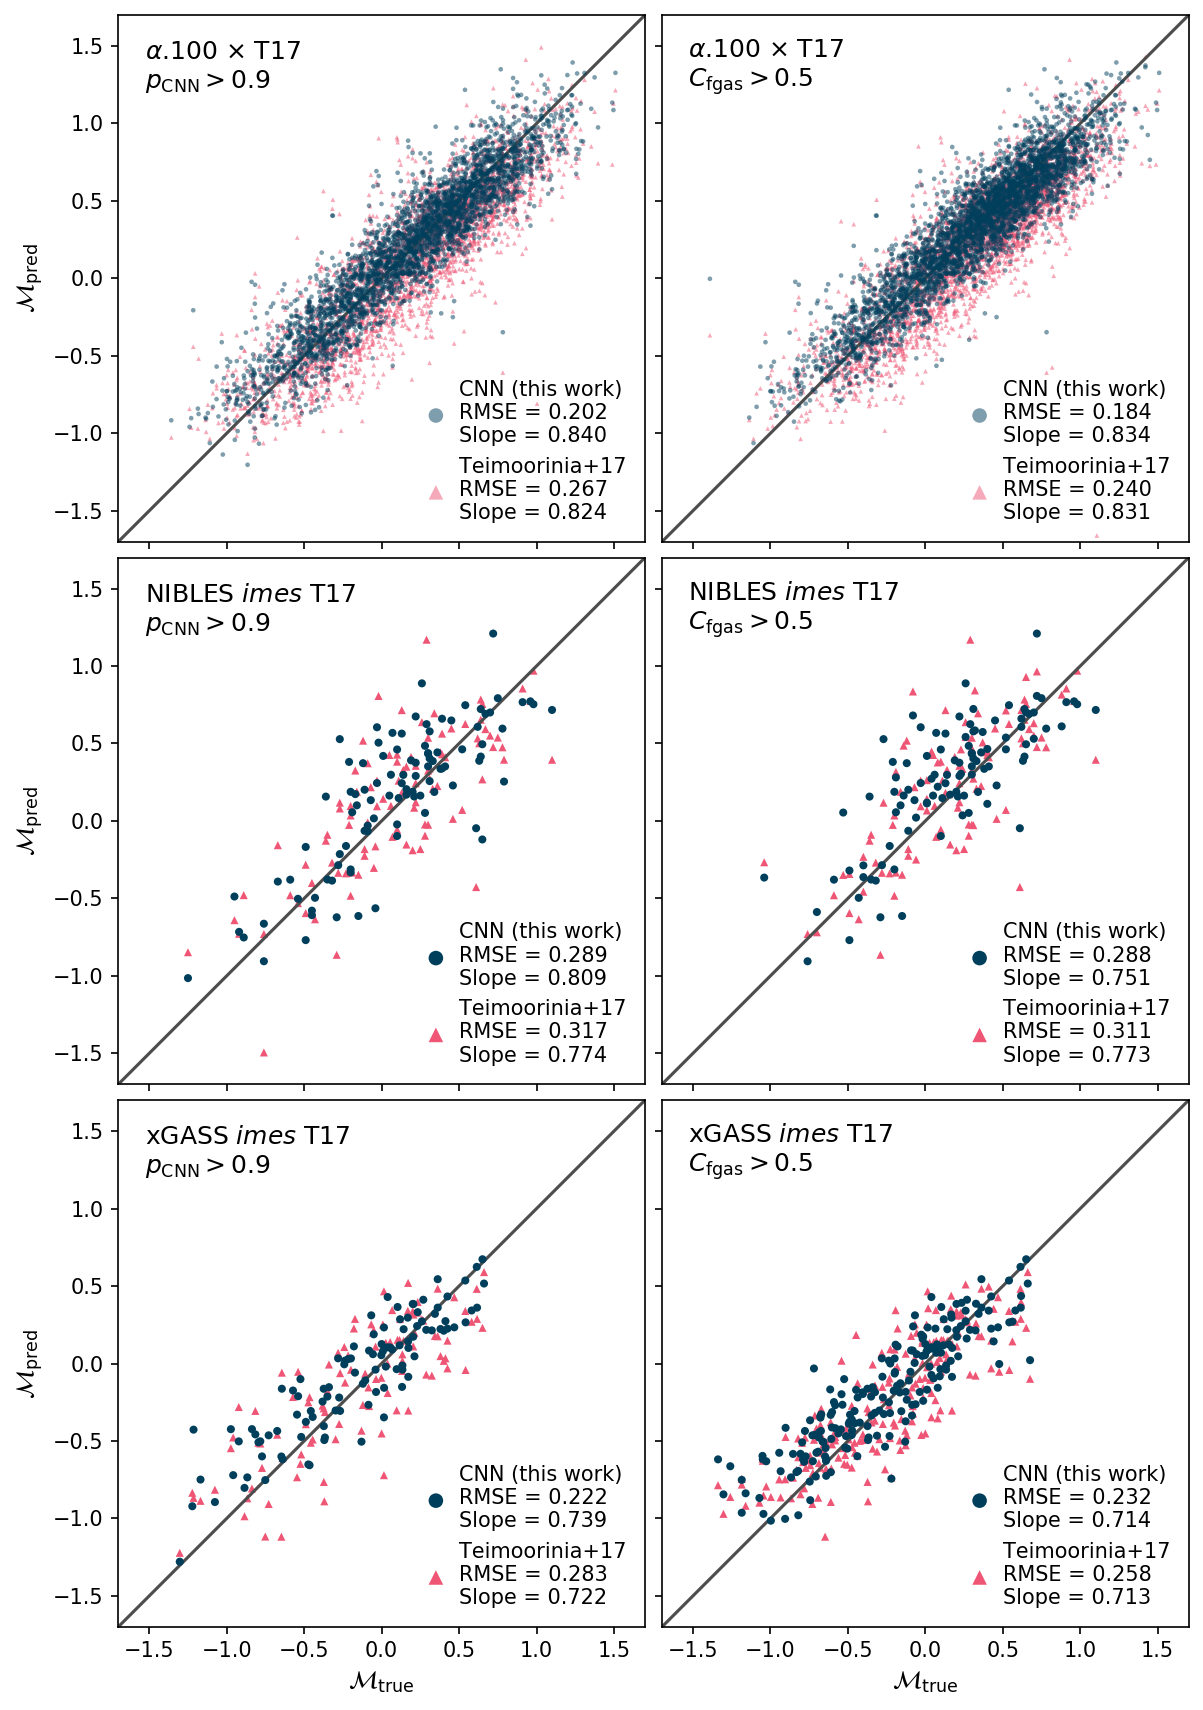

In [84]:
fig, axes = plt.subplots(3, 2, figsize=(8, 11.5), dpi=150, sharex=True, sharey=True, subplot_kw={'aspect':'equal'})

for i, [res, label, alpha, s] in enumerate(zip(
    [a100_x_t17, nib_x_t17, xg_x_t17], 
    [r'$\alpha$.100 $\times$ T17', 'NIBLES $\times$ T17', 'xGASS $\times$ T17'],
    [0.5, 1, 1],
    [5, 15, 15],
)):
    for j, [PR_accept, subtitle] in enumerate(zip(
        [res.p_CNN > 0.9, res.Cfgas > 0.5],
        [r'$p_{\rm CNN}>0.9$', r'$C_{\rm fgas}>0.5$'],
    )):
    
        ax = axes[i,j]
        
        # get stats
        N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
        _, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

        ax.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c='#003f5c', s=s, alpha=alpha, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}', zorder=9)
        ax.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='#ef5675', edgecolors='none', alpha=alpha, marker='^', s=s, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')

        ax.plot([-2.5, 2], [-2.5, 2], c='0.3')
        ax.set_aspect('equal')
        ax.set_xlim(-1.7, 1.7)
        ax.set_ylim(-1.7, 1.7)

        ax.legend(loc='lower right', fontsize=10, framealpha=0, markerscale=7/s**0.5, handletextpad=0.1)
        ax.text(0.05, 0.9, label + '\n' + subtitle, fontsize=12, ha='left', va='center', transform=ax.transAxes)
        
        if j == 0:
            ax.set_ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)
        
        if i == 2:
            ax.set_xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)

fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)

fig.savefig(f'{PATH}/results/final/CNN_x_T17-scatterplots_combined-all.pdf')

### Show results for no PR

In [89]:
a100 = pd.read_csv(f'{PATH}/results/final/a100_all.csv')
nib = pd.read_csv(f'{PATH}/results/final/nibles_all.csv')
xg = pd.read_csv(f'{PATH}/results/final/xgass_all.csv')

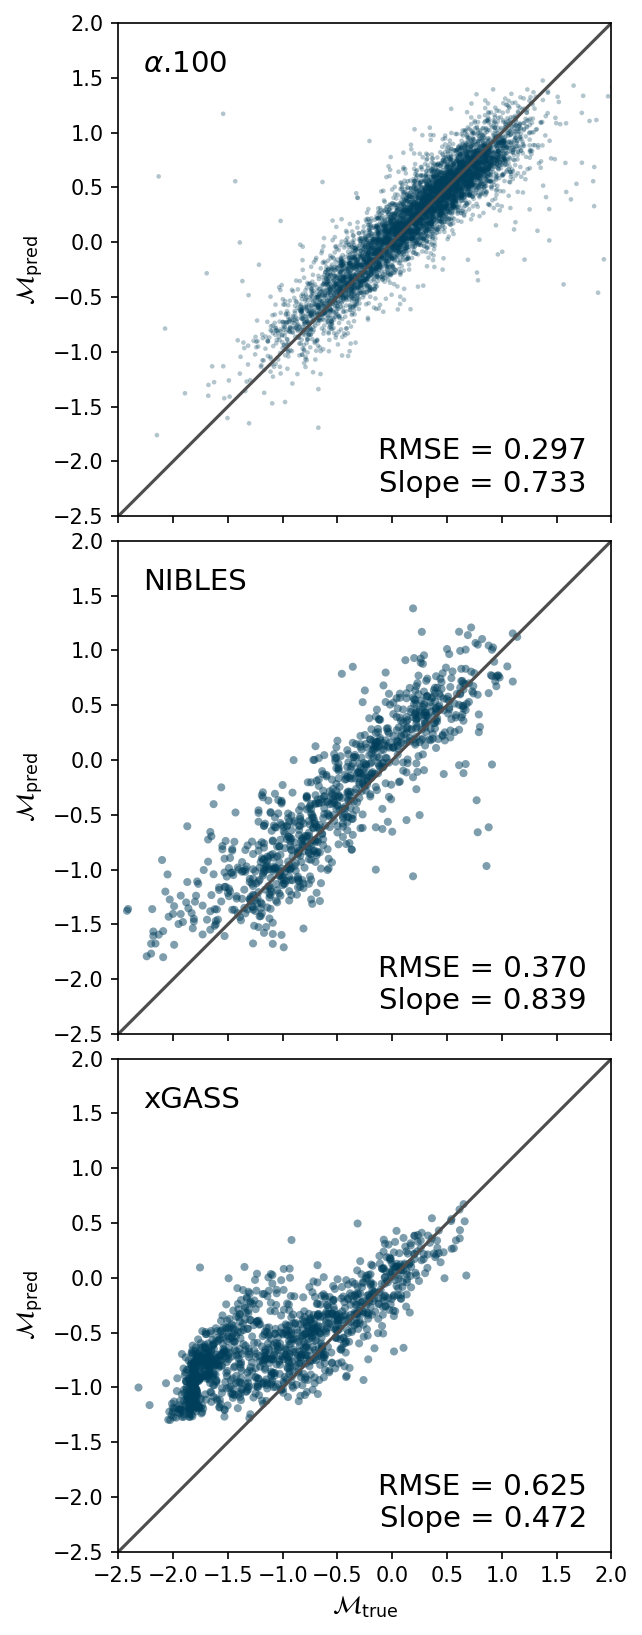

In [106]:
# no PR

fig, axes = plt.subplots(3, 1, figsize=(4, 11), dpi=150, sharex=True, sharey=True, subplot_kw={'aspect':'equal'})

for i, [res, label, alpha, s] in enumerate(zip(
    [a100, nib, xg], 
    [r'$\alpha$.100', 'NIBLES', 'xGASS'],
    [0.3, 0.5, 0.5],
    [5, 15, 15],
)):

    ax = axes[i]
    PR_accept = res.p_CNN >= 0

    # get stats
    _, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

    ax.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c='#003f5c', s=s, alpha=alpha, )

    ax.plot([-3, 2], [-3, 2], c='0.3')
    ax.set_aspect('equal')
    ax.set_xlim(-2.5, 2)
    ax.set_ylim(-2.5, 2)

    ax.text(0.95, 0.05, f'RMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}', fontsize=14, ha='right', transform=ax.transAxes)
    ax.text(0.05, 0.9, label, fontsize=14, ha='left', transform=ax.transAxes)
    
    ax.set_ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)
    if i == 2:
        ax.set_xticks(np.arange(-2.5, 2.5, 0.5))
        ax.set_xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)

fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

fig.savefig(f'{PATH}/results/final/CNN-scatterplots_combined.pdf')